## Imports

In [2]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
import math
import copy

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset
sys.path.insert(0, '../../Utils')

import models
from train import *
from metrics import * 
#from Gradient_Ascent import data_extraction
from skimage.restoration import denoise_nl_means, estimate_sigma

from PIL import Image
import pdb

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.7.2 (default, Feb 21 2019, 17:35:59) [MSC v.1915 64 bit (AMD64)]
Pytorch: 1.4.0+cu92


## Hyperparameters

In [3]:
n_epochs = 100
batch_size = 32
lr = 0.01

## Load ATT

In [4]:
data_dir = "..\\..\\attfaces"

img_paths = []
for p in os.listdir(data_dir): 
    for i in os.listdir(os.path.join(data_dir,p)): 
        img_paths.append(os.path.join(data_dir,p,i))
        
people = []
people_to_idx = {}
idx_to_people = {}
sample_paths = []
k = 0 
for i in img_paths: 
    name = i.split('\\')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = k
        idx_to_people[k] = name
        k += 1
        sample_paths.append(i)

img_paths = np.random.permutation(img_paths)

lfw_size = len(img_paths)
lfw_train_size = int(0.7 * lfw_size)
lfw_train_list = img_paths[:lfw_train_size]
lfw_test_list = img_paths[lfw_train_size:]

class ATTdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        
        image = np.empty((112, 92, 1), dtype=np.uint8)
        img_path = self.file_list[idx]
        im = io.imread(img_path)
        im = im.reshape(112,92)
        image[:,:,0]= im
#         image[:,:,1]= im
#         image[:,:,2]= im
        # pdb.set_trace()
        label = self.people_to_idx[img_path.split('\\')[-2]]
        
        if self.transform is not None: 
            image = self.transform(image)
        
        return image, label
        

# Data augmentation 
train_transform = torchvision.transforms.Compose([

#     torchvision.transforms.ToPILImage(),
#     torchvision.transforms.CenterCrop((92,92)),    
#     torchvision.transforms.Resize((128,128)),
    torchvision.transforms.ToTensor(),

    
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
    

trainset = ATTdataset(lfw_train_list, people_to_idx, transform=train_transform)
testset = ATTdataset(lfw_test_list, people_to_idx, transform=test_transform)
sampleset = ATTdataset(sample_paths, people_to_idx, transform=torchvision.transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
sampleloader = torch.utils.data.DataLoader(sampleset, batch_size=40, shuffle=False, num_workers=0)

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> torch.Size([3, 572, 754])
<class 'numpy.ndarray'> (3, 572, 754)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])
tensor(0.)
tensor(0.9569)
torch.Size([40, 1, 112, 92])


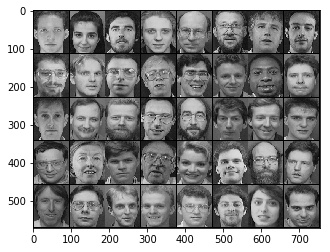

In [5]:
# helper function to unnormalize and plot image 
def imshow(img, name):
    print(type(img), img.shape)
    img = np.array(img)
    #img = img / 2 + 0.5
    print(type(img), img.shape)
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    plt.imsave('.\\'+name, img)
    
# display sample from dataset 
imgs,labels = iter(sampleloader).next()
print(type(imgs), type(torchvision.utils.make_grid(imgs)))
imshow(torchvision.utils.make_grid(imgs),'origin') 
print(labels)
print(imgs.min())
print(imgs.max())
print(imgs.shape)

## Model Architecture

In [6]:
class mlp(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=3000): 
        super(mlp, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_out)        

    def forward(self, x):
        x = x.view(-1,112*92)
        out = self.hidden1(x)
        return out

In [7]:
# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = mlp().to(device)
net.apply(models.weights_init)

net2 = mlp().to(device)
net2.apply(models.weights_init)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)


ww0 = copy.deepcopy(net2.hidden1.weight.data)
bb = copy.deepcopy(net2.hidden1.bias.data[:])
#im0 = ww0[34].reshape(112,92)

## Training 

In [8]:
train(net, trainloader, testloader, optimizer, criterion, n_epochs, verbose=False)

[0/100]
Training:

Accuracy = 8.21 %


Test:

Accuracy = 3.33 %


[1/100]
Training:

Accuracy = 12.50 %


Test:

Accuracy = 6.67 %


[2/100]
Training:

Accuracy = 14.64 %


Test:

Accuracy = 10.83 %


[3/100]
Training:

Accuracy = 20.00 %


Test:

Accuracy = 17.50 %


[4/100]
Training:

Accuracy = 37.50 %


Test:

Accuracy = 30.83 %


[5/100]
Training:

Accuracy = 53.93 %


Test:

Accuracy = 41.67 %


[6/100]
Training:

Accuracy = 63.93 %


Test:

Accuracy = 56.67 %


[7/100]
Training:

Accuracy = 74.29 %


Test:

Accuracy = 45.00 %


[8/100]
Training:

Accuracy = 77.86 %


Test:

Accuracy = 70.00 %


[9/100]
Training:

Accuracy = 86.43 %


Test:

Accuracy = 74.17 %


[10/100]
Training:

Accuracy = 90.71 %


Test:

Accuracy = 76.67 %


[11/100]
Training:

Accuracy = 93.21 %


Test:

Accuracy = 74.17 %


[12/100]
Training:

Accuracy = 90.71 %


Test:

Accuracy = 77.50 %


[13/100]
Training:

Accuracy = 96.79 %


Test:

Accuracy = 77.50 %


[14/100]
Training:

Accuracy = 94.29 %


Test:


(100.0, 94.16666666666667)

In [9]:
train(net2, trainloader, testloader, optimizer2, criterion, n_epochs, verbose=False)

[0/100]
Training:

Accuracy = 13.93 %


Test:

Accuracy = 7.50 %


[1/100]
Training:

Accuracy = 43.93 %


Test:

Accuracy = 45.83 %


[2/100]
Training:

Accuracy = 56.79 %


Test:

Accuracy = 39.17 %


[3/100]
Training:

Accuracy = 61.79 %


Test:

Accuracy = 36.67 %


[4/100]
Training:

Accuracy = 77.14 %


Test:

Accuracy = 64.17 %


[5/100]
Training:

Accuracy = 89.64 %


Test:

Accuracy = 77.50 %


[6/100]
Training:

Accuracy = 91.07 %


Test:

Accuracy = 72.50 %


[7/100]
Training:

Accuracy = 99.64 %


Test:

Accuracy = 84.17 %


[8/100]
Training:

Accuracy = 95.71 %


Test:

Accuracy = 85.83 %


[9/100]
Training:

Accuracy = 97.50 %


Test:

Accuracy = 84.17 %


[10/100]
Training:

Accuracy = 97.86 %


Test:

Accuracy = 89.17 %


[11/100]
Training:

Accuracy = 97.86 %


Test:

Accuracy = 85.83 %


[12/100]
Training:

Accuracy = 99.64 %


Test:

Accuracy = 90.83 %


[13/100]
Training:

Accuracy = 99.64 %


Test:

Accuracy = 95.00 %


[14/100]
Training:

Accuracy = 100.00 %


Tes

(100.0, 95.0)

In [45]:
noise = 0.01 * torch.randn(ww.shape).to(device)
print(type(noise))
print(noise.max())
print(noise.min())
print(noise.shape)
ww = ww + noise
net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] + noise
print(ww)
print(net2.hidden1.weight.data[:])
print(ww == net2.hidden1.weight.data[:])

<class 'torch.Tensor'>
tensor(0.0462, device='cuda:0')
tensor(-0.0445, device='cuda:0')
torch.Size([40, 10304])
tensor([[-0.0358, -0.0075, -0.0004,  ..., -0.0338, -0.0067,  0.0073],
        [ 0.0372,  0.0235, -0.0075,  ..., -0.0158, -0.0150, -0.0213],
        [-0.0223, -0.0094, -0.0277,  ..., -0.0259,  0.0166, -0.0289],
        ...,
        [ 0.0037,  0.0280,  0.0015,  ...,  0.0121,  0.0550,  0.0102],
        [ 0.0220, -0.0116,  0.0130,  ...,  0.0115,  0.0234,  0.0016],
        [-0.0126,  0.0093,  0.0184,  ..., -0.0037,  0.0083, -0.0088]],
       device='cuda:0')
tensor([[-0.0358, -0.0075, -0.0004,  ..., -0.0338, -0.0067,  0.0073],
        [ 0.0372,  0.0235, -0.0075,  ..., -0.0158, -0.0150, -0.0213],
        [-0.0223, -0.0094, -0.0277,  ..., -0.0259,  0.0166, -0.0289],
        ...,
        [ 0.0037,  0.0280,  0.0015,  ...,  0.0121,  0.0550,  0.0102],
        [ 0.0220, -0.0116,  0.0130,  ...,  0.0115,  0.0234,  0.0016],
        [-0.0126,  0.0093,  0.0184,  ..., -0.0037,  0.0083, -0.0088

torch.Size([40, 1, 112, 92])
tensor([[-0.0358, -0.0075, -0.0004,  ..., -0.0338, -0.0067,  0.0073],
        [ 0.0372,  0.0235, -0.0075,  ..., -0.0158, -0.0150, -0.0213],
        [-0.0223, -0.0094, -0.0277,  ..., -0.0259,  0.0166, -0.0289],
        ...,
        [ 0.0037,  0.0280,  0.0015,  ...,  0.0121,  0.0550,  0.0102],
        [ 0.0220, -0.0116,  0.0130,  ...,  0.0115,  0.0234,  0.0016],
        [-0.0126,  0.0093,  0.0184,  ..., -0.0037,  0.0083, -0.0088]],
       device='cuda:0') tensor(-0.0925, device='cuda:0') tensor(0.1197, device='cuda:0') torch.Size([40, 10304])


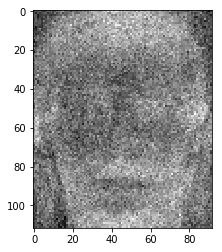

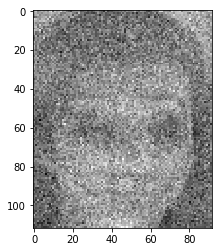

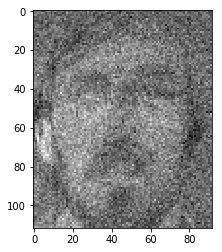

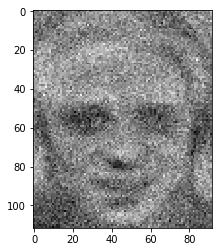

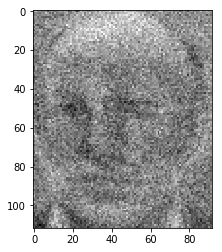

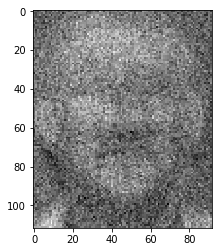

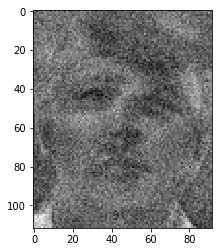

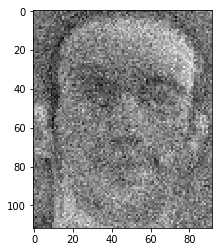

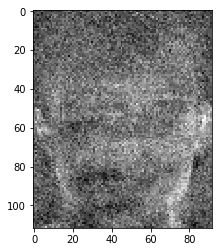

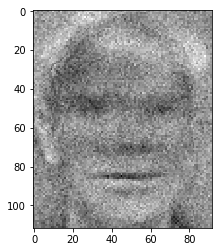

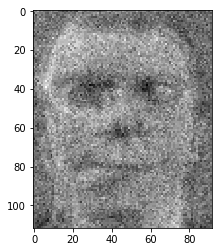

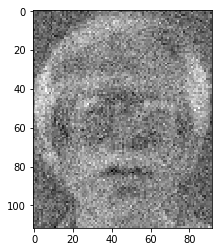

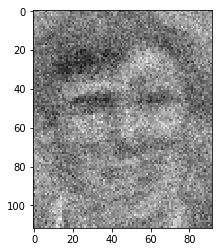

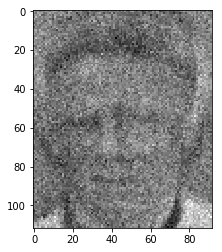

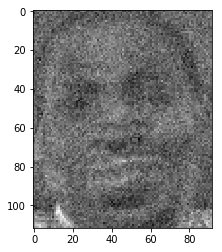

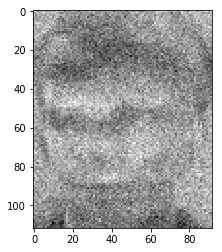

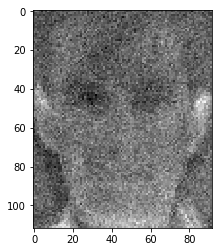

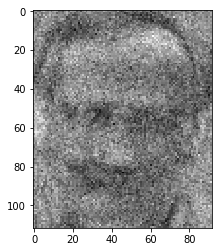

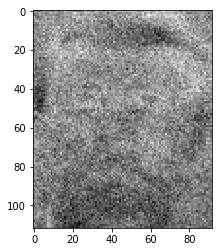

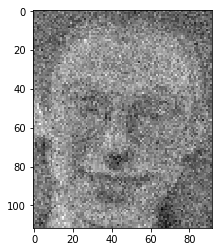

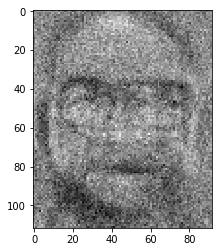

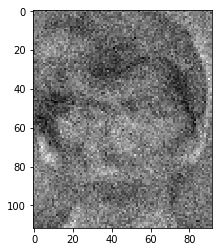

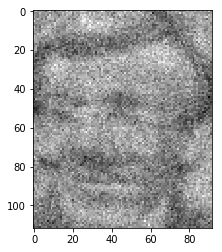

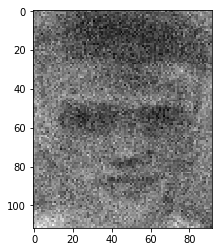

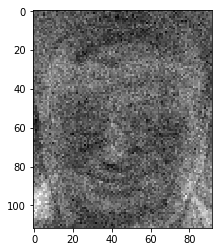

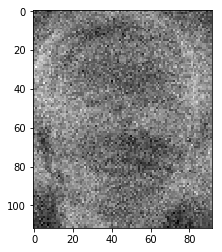

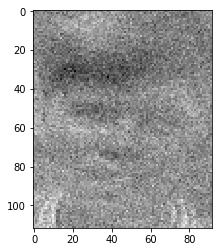

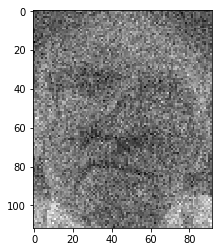

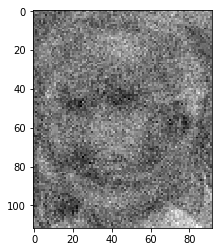

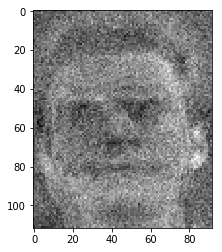

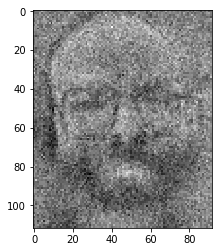

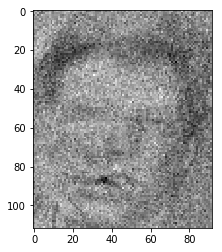

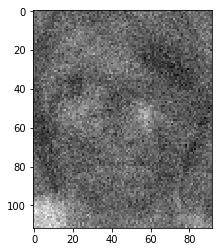

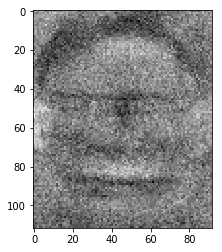

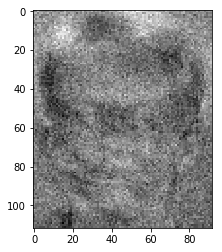

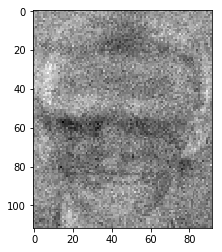

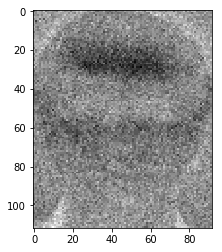

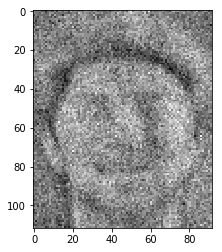

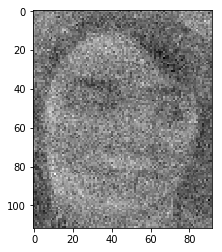

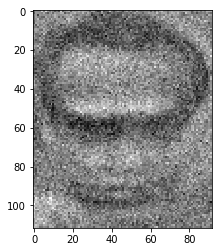

In [47]:
print(imgs.shape)
ww = net2.hidden1.weight.data[:]
bb = net2.hidden1.bias.data[:]

print(ww, ww.min(),ww.max(),ww.shape)

for i in range(40):
    im0 = ww0[i,:].reshape(1,1,112,92)
    im_train = ww[i,:].reshape(1,1,112,92)
    plt.imshow((im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
    plt.imsave('.\\mlp\\{0}'.format(idx_to_people[i]), (im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
    plt.show()

    

# im_train = ww[34,:].squeeze().cpu().detach().numpy().reshape(112,92)
# plt.imshow(im0.squeeze().cpu().detach().numpy(),cmap='gray')
# plt.show()

# plt.imshow(im_train,cmap='gray')
# plt.show()

# plt.imshow(im_train-im0.squeeze().cpu().detach().numpy(),cmap='gray')
# plt.show()

# plt.imshow(im_train-torch.randn(im_train.shape)/100,cmap='gray')
# plt.show()
# # print(torch.sum())

In [48]:
eval_target_net(net2, testloader)
print(net2.hidden1.weight.data[:])


Accuracy = 95.83 %


tensor([[-0.0358, -0.0075, -0.0004,  ..., -0.0338, -0.0067,  0.0073],
        [ 0.0372,  0.0235, -0.0075,  ..., -0.0158, -0.0150, -0.0213],
        [-0.0223, -0.0094, -0.0277,  ..., -0.0259,  0.0166, -0.0289],
        ...,
        [ 0.0037,  0.0280,  0.0015,  ...,  0.0121,  0.0550,  0.0102],
        [ 0.0220, -0.0116,  0.0130,  ...,  0.0115,  0.0234,  0.0016],
        [-0.0126,  0.0093,  0.0184,  ..., -0.0037,  0.0083, -0.0088]],
       device='cuda:0')


<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> torch.Size([4, 572, 754])
<class 'numpy.ndarray'> (4, 572, 754)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])
tensor(0.)
tensor(1.)
torch.Size([40, 4, 112, 92])


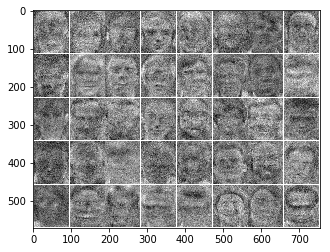

In [49]:
class MLPdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        data = np.asarray(img)
        label = people_to_idx[img_path.split('\\')[-1].split('.')[-2]]
        if self.transform is not None: 
            img = self.transform(img)
        
        return img, label

mlp_dir = ".\\mlp\\"

mlp_paths = []
for p in os.listdir(mlp_dir): 
    mlp_paths.append(os.path.join(mlp_dir,p))
        
mlpset = MLPdataset(mlp_paths, people_to_idx, transform=torchvision.transforms.ToTensor())
mlploader = torch.utils.data.DataLoader(mlpset, batch_size=40, shuffle=False, num_workers=0)

mlp_imgs,labels = iter(mlploader).next()
print(type(mlp_imgs), type(torchvision.utils.make_grid(mlp_imgs)))
imshow(torchvision.utils.make_grid(mlp_imgs), 'after') 
print(labels)
print(mlp_imgs.min())
print(mlp_imgs.max())
print(mlp_imgs.shape)

In [52]:
ww = ww - noise
net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] - noise
print(ww, net2.hidden1.weight.data[:])

tensor([[-0.0306, -0.0153, -0.0047,  ..., -0.0318, -0.0105,  0.0056],
        [ 0.0348,  0.0121,  0.0042,  ..., -0.0196, -0.0135, -0.0074],
        [-0.0310, -0.0172, -0.0275,  ..., -0.0156,  0.0093, -0.0286],
        ...,
        [-0.0070,  0.0233, -0.0040,  ...,  0.0165,  0.0338,  0.0016],
        [ 0.0267, -0.0057,  0.0103,  ...,  0.0135,  0.0132, -0.0075],
        [-0.0029,  0.0039,  0.0154,  ..., -0.0047,  0.0081,  0.0048]],
       device='cuda:0') tensor([[-0.0306, -0.0153, -0.0047,  ..., -0.0318, -0.0105,  0.0056],
        [ 0.0348,  0.0121,  0.0042,  ..., -0.0196, -0.0135, -0.0074],
        [-0.0310, -0.0172, -0.0275,  ..., -0.0156,  0.0093, -0.0286],
        ...,
        [-0.0070,  0.0233, -0.0040,  ...,  0.0165,  0.0338,  0.0016],
        [ 0.0267, -0.0057,  0.0103,  ...,  0.0135,  0.0132, -0.0075],
        [-0.0029,  0.0039,  0.0154,  ..., -0.0047,  0.0081,  0.0048]],
       device='cuda:0')


## Gradient Ascent

In [18]:
from torch.autograd import Variable

def ga(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses = []
    grad0 = np.zeros((112,92))
    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            
#             out = nn.functional.softmax(net(input), dim=1)
            out = net(input)
            loss= -out.take(category)#+reg_alpha
            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        losses.append(loss.data)
#         print(j)
        grad0=input.grad.data.squeeze().cpu().detach().numpy()
        input.grad.data = input.grad.data - input.grad.data
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

In [19]:
from torch.autograd import Variable
def ga_adam(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses=[]

    v_x = torch.tensor(np.zeros((112,92))).unsqueeze(0).float().cuda()
    m_x = torch.tensor(np.zeros((112,92))).unsqueeze(0).float().cuda()
    beta1 = torch.tensor(0.9).cuda()
    beta2 = torch.tensor(0.99).cuda()
    eps = torch.tensor(1e-6).cuda()
    
    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            out = nn.functional.softmax(net(input), dim=1)
            loss= -out.take(category)#+reg_alpha
            
            loss.backward()
            
            m_x = beta1 *m_x + (1-beta1) * input.grad.data       
            v_x = beta2 *v_x + (1-beta2) * input.grad.data**2
            input.data = input.data - lr * m_x / torch.sqrt(v_x+eps)
            input.grad.zero_()
#             input.data = input.data - lr * input.grad.data
        print(j)
        print(loss.data)
        print(-out.take(category))
        losses.append(loss.data)
        plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray')
        plt.show()
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

In [ ]:
# import os
# import imageio

# png_dir = 'png/'
# images = []
# # for file_name in os.listdir(png_dir):
# for i in range(100):
#     filename = f"Results/2Fred {i}.png" 
# #     if file_name.endswith('dog_dream_%i.png' %(i)):
# #     file_path = os.path.join(png_dir, file_name)
#     images.append(imageio.imread(filename))
        
# kargs = { 'duration': 0.1 }
# imageio.mimsave('movie.gif', images,**kargs)

## Overfitted model

Gradient Ascent optimizes an input image to maximize the posterior of a particular category. 

Gradient Ascent reconstructs the memorized image within the parameters. If the model is well generalized with a lower learning rate and higher testing accuracy the method is not as effective. Although new results show that if the initial model parameters are subtracted from the reconstruction an accurate reconstruction will be generated.

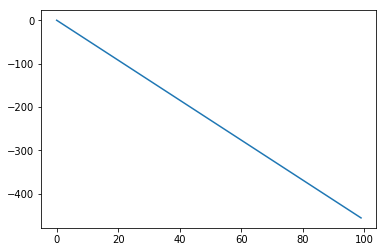

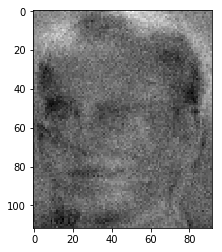

In [20]:

# np_page=np.random.random((112,92))
np_page=np.zeros((112,92))

dream_ga=ga(torch.Tensor((np_page)),net,100,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

## More generalized model

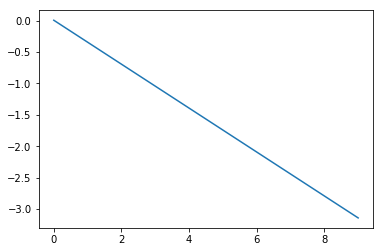

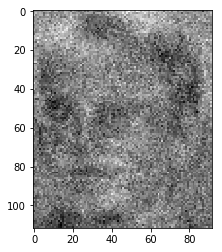

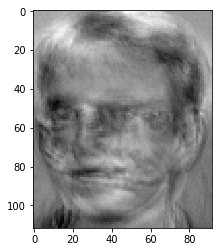

In [22]:
# np_page=np.random.random((112,92))
np_page=np.zeros((112,92))

dream_ga=ga(torch.Tensor((np_page)),net2,10,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
# plt.imsave("noisy.png",dream_ga.squeeze().cpu().detach().numpy(),cmap = 'gray',format='png')
# plt.imsave("noise.png",im0,cmap = 'gray',format='png')
# plt.imsave("noisy-noise.png",dream_ga.squeeze().cpu().detach().numpy()-im0,cmap = 'gray',format='png')
plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im0.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [ ]:
# # plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im0*.2253,cmap='gray')
# plt.imshow(dream_ga.mean().cpu().detach().numpy()-im_train*.2253,cmap='gray')
# print((dream_ga/im0).mean())
# # print((im0*dream_ga.mean().cpu().detach().numpy()/im0.mean()).mean())
# # print(dream_ga.squeeze().cpu().detach().numpy().mean())
# # print((dream_ga.mean().cpu().detach().numpy()/im_train).mean())
# plt.show()
# plt.imshow((dream_ga/im0).squeeze().cpu().detach().numpy(),vmin=100,vmax=1000)
# plt.show()

## Regularization

In [23]:
alpha_reg_alpha = 6
def alpha_norm(input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm


def ga_norm(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses=[]

    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            out = nn.functional.softmax(net(input), dim=1)
            reg_alpha = alpha_norm(input, alpha_reg_alpha)/1000
            loss= -out.take(category)+reg_alpha
            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        print(j)
        print(loss.data)
        print(-out.take(category))
        losses.append(loss.data)
        plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1)
        plt.show()
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

0
tensor([-0.0248], device='cuda:0')
tensor([-0.0248], device='cuda:0', grad_fn=<NegBackward>)


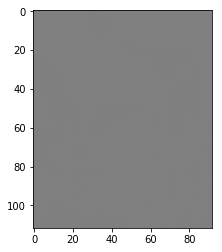

1
tensor([-0.0250], device='cuda:0')
tensor([-0.0250], device='cuda:0', grad_fn=<NegBackward>)


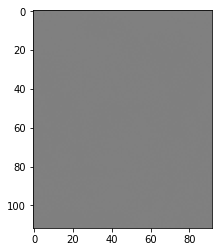

2
tensor([-0.0253], device='cuda:0')
tensor([-0.0253], device='cuda:0', grad_fn=<NegBackward>)


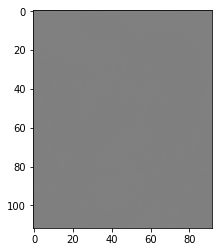

3
tensor([-0.0255], device='cuda:0')
tensor([-0.0255], device='cuda:0', grad_fn=<NegBackward>)


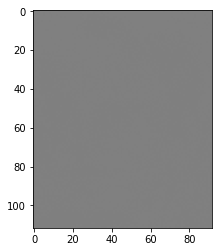

4
tensor([-0.0257], device='cuda:0')
tensor([-0.0257], device='cuda:0', grad_fn=<NegBackward>)


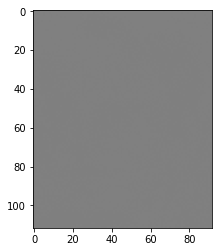

5
tensor([-0.0259], device='cuda:0')
tensor([-0.0259], device='cuda:0', grad_fn=<NegBackward>)


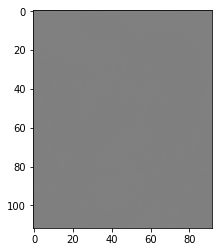

6
tensor([-0.0262], device='cuda:0')
tensor([-0.0262], device='cuda:0', grad_fn=<NegBackward>)


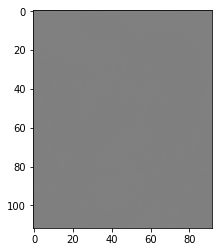

7
tensor([-0.0264], device='cuda:0')
tensor([-0.0264], device='cuda:0', grad_fn=<NegBackward>)


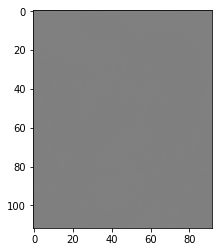

8
tensor([-0.0266], device='cuda:0')
tensor([-0.0266], device='cuda:0', grad_fn=<NegBackward>)


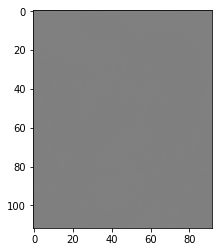

9
tensor([-0.0269], device='cuda:0')
tensor([-0.0269], device='cuda:0', grad_fn=<NegBackward>)


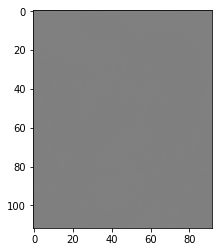

10
tensor([-0.0271], device='cuda:0')
tensor([-0.0271], device='cuda:0', grad_fn=<NegBackward>)


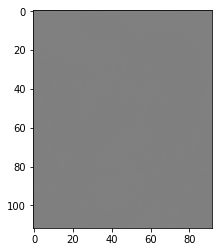

11
tensor([-0.0274], device='cuda:0')
tensor([-0.0274], device='cuda:0', grad_fn=<NegBackward>)


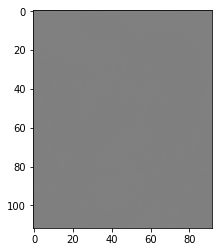

12
tensor([-0.0277], device='cuda:0')
tensor([-0.0277], device='cuda:0', grad_fn=<NegBackward>)


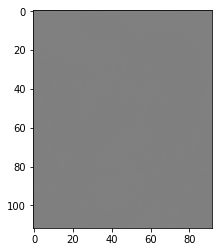

13
tensor([-0.0279], device='cuda:0')
tensor([-0.0279], device='cuda:0', grad_fn=<NegBackward>)


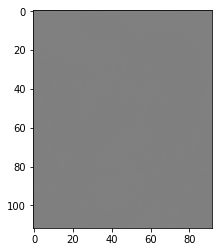

14
tensor([-0.0282], device='cuda:0')
tensor([-0.0282], device='cuda:0', grad_fn=<NegBackward>)


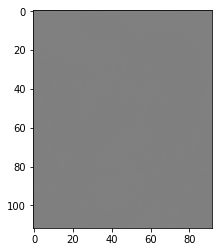

15
tensor([-0.0285], device='cuda:0')
tensor([-0.0285], device='cuda:0', grad_fn=<NegBackward>)


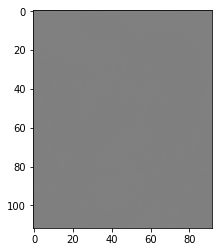

16
tensor([-0.0287], device='cuda:0')
tensor([-0.0287], device='cuda:0', grad_fn=<NegBackward>)


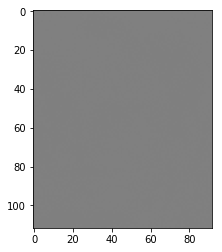

17
tensor([-0.0290], device='cuda:0')
tensor([-0.0290], device='cuda:0', grad_fn=<NegBackward>)


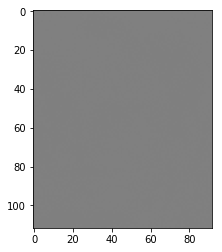

18
tensor([-0.0293], device='cuda:0')
tensor([-0.0293], device='cuda:0', grad_fn=<NegBackward>)


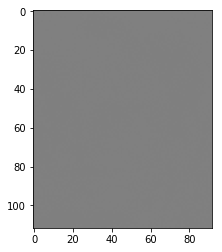

19
tensor([-0.0296], device='cuda:0')
tensor([-0.0296], device='cuda:0', grad_fn=<NegBackward>)


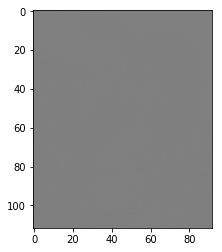

20
tensor([-0.0299], device='cuda:0')
tensor([-0.0299], device='cuda:0', grad_fn=<NegBackward>)


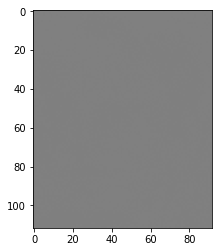

21
tensor([-0.0302], device='cuda:0')
tensor([-0.0302], device='cuda:0', grad_fn=<NegBackward>)


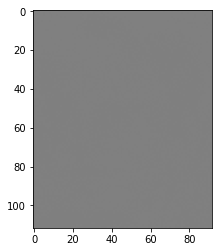

22
tensor([-0.0305], device='cuda:0')
tensor([-0.0305], device='cuda:0', grad_fn=<NegBackward>)


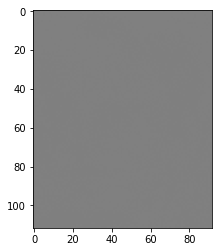

23
tensor([-0.0309], device='cuda:0')
tensor([-0.0309], device='cuda:0', grad_fn=<NegBackward>)


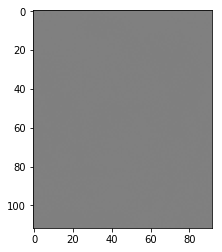

24
tensor([-0.0312], device='cuda:0')
tensor([-0.0312], device='cuda:0', grad_fn=<NegBackward>)


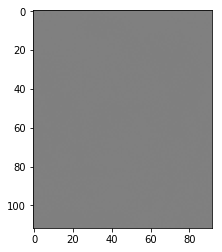

25
tensor([-0.0315], device='cuda:0')
tensor([-0.0315], device='cuda:0', grad_fn=<NegBackward>)


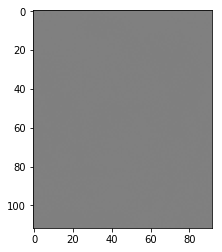

26
tensor([-0.0319], device='cuda:0')
tensor([-0.0319], device='cuda:0', grad_fn=<NegBackward>)


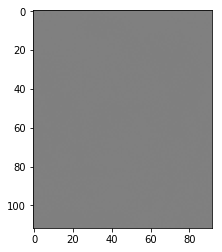

27
tensor([-0.0322], device='cuda:0')
tensor([-0.0322], device='cuda:0', grad_fn=<NegBackward>)


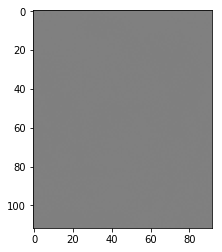

28
tensor([-0.0326], device='cuda:0')
tensor([-0.0326], device='cuda:0', grad_fn=<NegBackward>)


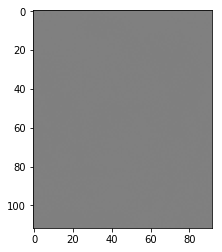

29
tensor([-0.0329], device='cuda:0')
tensor([-0.0329], device='cuda:0', grad_fn=<NegBackward>)


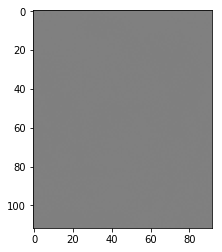

30
tensor([-0.0333], device='cuda:0')
tensor([-0.0333], device='cuda:0', grad_fn=<NegBackward>)


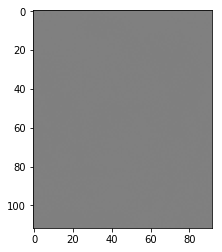

31
tensor([-0.0337], device='cuda:0')
tensor([-0.0337], device='cuda:0', grad_fn=<NegBackward>)


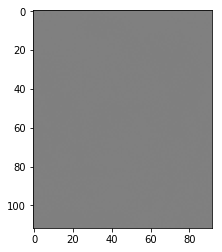

32
tensor([-0.0340], device='cuda:0')
tensor([-0.0340], device='cuda:0', grad_fn=<NegBackward>)


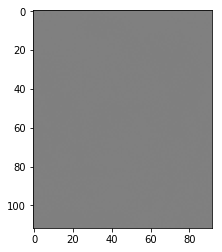

33
tensor([-0.0344], device='cuda:0')
tensor([-0.0344], device='cuda:0', grad_fn=<NegBackward>)


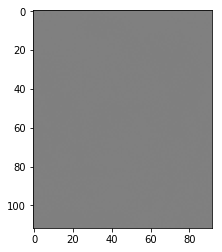

34
tensor([-0.0348], device='cuda:0')
tensor([-0.0348], device='cuda:0', grad_fn=<NegBackward>)


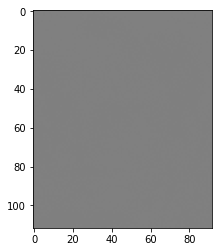

35
tensor([-0.0353], device='cuda:0')
tensor([-0.0353], device='cuda:0', grad_fn=<NegBackward>)


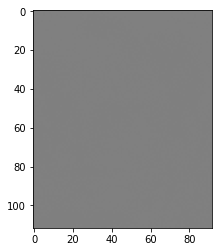

36
tensor([-0.0357], device='cuda:0')
tensor([-0.0357], device='cuda:0', grad_fn=<NegBackward>)


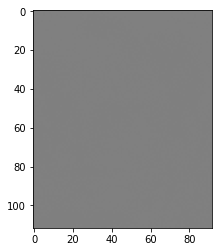

37
tensor([-0.0361], device='cuda:0')
tensor([-0.0361], device='cuda:0', grad_fn=<NegBackward>)


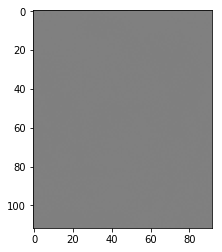

38
tensor([-0.0366], device='cuda:0')
tensor([-0.0366], device='cuda:0', grad_fn=<NegBackward>)


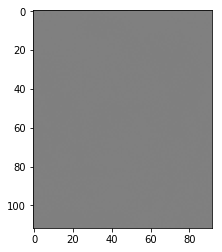

39
tensor([-0.0370], device='cuda:0')
tensor([-0.0370], device='cuda:0', grad_fn=<NegBackward>)


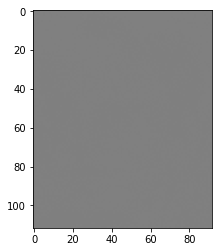

40
tensor([-0.0375], device='cuda:0')
tensor([-0.0375], device='cuda:0', grad_fn=<NegBackward>)


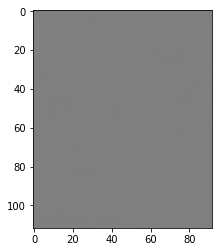

41
tensor([-0.0379], device='cuda:0')
tensor([-0.0379], device='cuda:0', grad_fn=<NegBackward>)


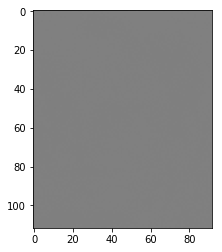

42
tensor([-0.0384], device='cuda:0')
tensor([-0.0384], device='cuda:0', grad_fn=<NegBackward>)


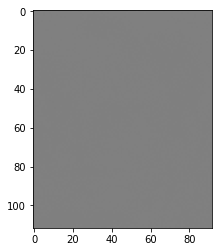

43
tensor([-0.0389], device='cuda:0')
tensor([-0.0389], device='cuda:0', grad_fn=<NegBackward>)


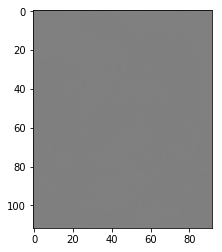

44
tensor([-0.0394], device='cuda:0')
tensor([-0.0394], device='cuda:0', grad_fn=<NegBackward>)


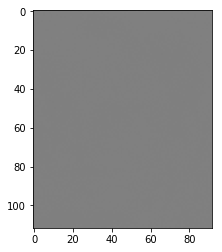

45
tensor([-0.0400], device='cuda:0')
tensor([-0.0400], device='cuda:0', grad_fn=<NegBackward>)


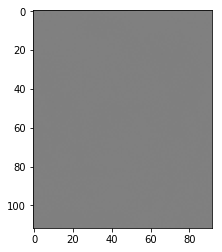

46
tensor([-0.0405], device='cuda:0')
tensor([-0.0405], device='cuda:0', grad_fn=<NegBackward>)


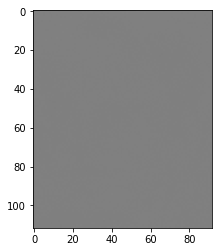

47
tensor([-0.0411], device='cuda:0')
tensor([-0.0411], device='cuda:0', grad_fn=<NegBackward>)


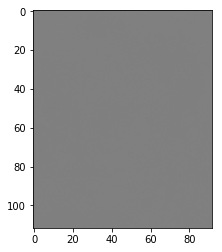

48
tensor([-0.0416], device='cuda:0')
tensor([-0.0416], device='cuda:0', grad_fn=<NegBackward>)


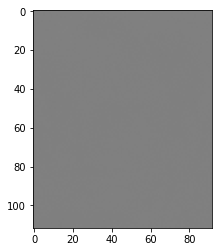

49
tensor([-0.0422], device='cuda:0')
tensor([-0.0422], device='cuda:0', grad_fn=<NegBackward>)


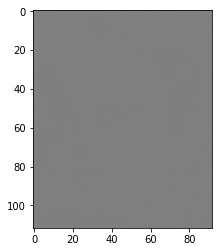

50
tensor([-0.0428], device='cuda:0')
tensor([-0.0428], device='cuda:0', grad_fn=<NegBackward>)


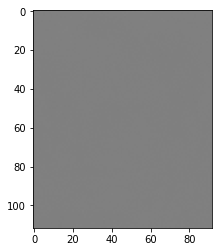

51
tensor([-0.0434], device='cuda:0')
tensor([-0.0434], device='cuda:0', grad_fn=<NegBackward>)


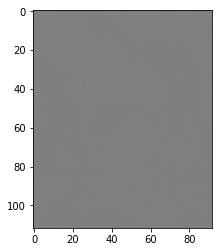

52
tensor([-0.0440], device='cuda:0')
tensor([-0.0440], device='cuda:0', grad_fn=<NegBackward>)


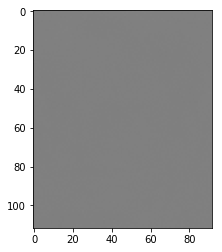

53
tensor([-0.0447], device='cuda:0')
tensor([-0.0447], device='cuda:0', grad_fn=<NegBackward>)


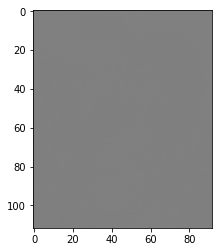

54
tensor([-0.0454], device='cuda:0')
tensor([-0.0454], device='cuda:0', grad_fn=<NegBackward>)


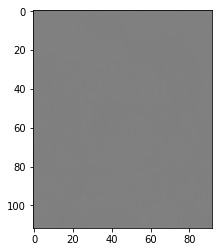

55
tensor([-0.0460], device='cuda:0')
tensor([-0.0460], device='cuda:0', grad_fn=<NegBackward>)


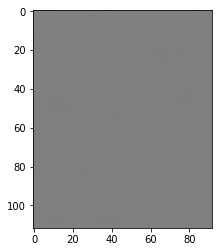

56
tensor([-0.0467], device='cuda:0')
tensor([-0.0467], device='cuda:0', grad_fn=<NegBackward>)


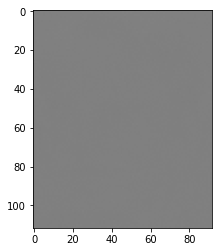

57
tensor([-0.0475], device='cuda:0')
tensor([-0.0475], device='cuda:0', grad_fn=<NegBackward>)


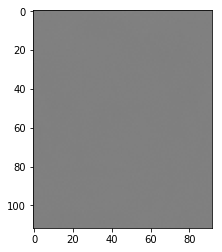

58
tensor([-0.0482], device='cuda:0')
tensor([-0.0482], device='cuda:0', grad_fn=<NegBackward>)


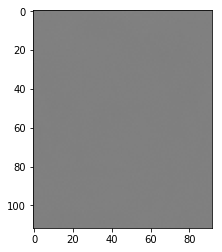

59
tensor([-0.0490], device='cuda:0')
tensor([-0.0490], device='cuda:0', grad_fn=<NegBackward>)


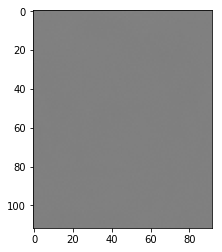

60
tensor([-0.0498], device='cuda:0')
tensor([-0.0498], device='cuda:0', grad_fn=<NegBackward>)


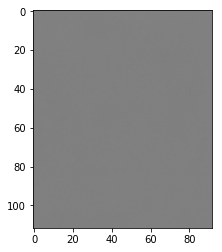

61
tensor([-0.0506], device='cuda:0')
tensor([-0.0506], device='cuda:0', grad_fn=<NegBackward>)


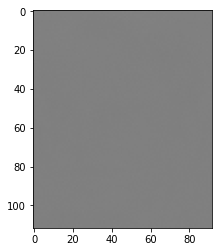

62
tensor([-0.0514], device='cuda:0')
tensor([-0.0514], device='cuda:0', grad_fn=<NegBackward>)


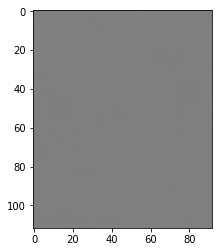

63
tensor([-0.0523], device='cuda:0')
tensor([-0.0523], device='cuda:0', grad_fn=<NegBackward>)


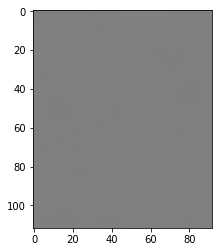

64
tensor([-0.0532], device='cuda:0')
tensor([-0.0532], device='cuda:0', grad_fn=<NegBackward>)


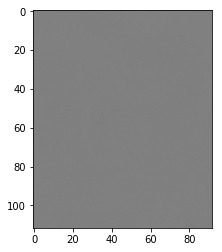

65
tensor([-0.0541], device='cuda:0')
tensor([-0.0541], device='cuda:0', grad_fn=<NegBackward>)


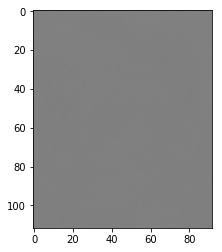

66
tensor([-0.0551], device='cuda:0')
tensor([-0.0551], device='cuda:0', grad_fn=<NegBackward>)


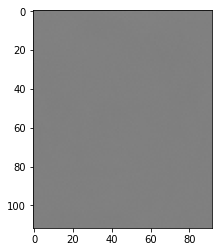

67
tensor([-0.0561], device='cuda:0')
tensor([-0.0561], device='cuda:0', grad_fn=<NegBackward>)


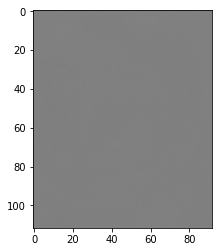

68
tensor([-0.0571], device='cuda:0')
tensor([-0.0571], device='cuda:0', grad_fn=<NegBackward>)


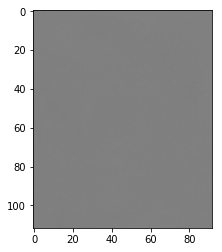

69
tensor([-0.0581], device='cuda:0')
tensor([-0.0581], device='cuda:0', grad_fn=<NegBackward>)


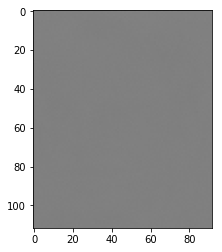

70
tensor([-0.0592], device='cuda:0')
tensor([-0.0592], device='cuda:0', grad_fn=<NegBackward>)


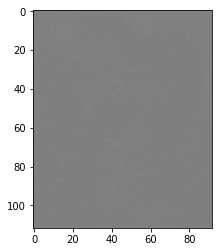

71
tensor([-0.0604], device='cuda:0')
tensor([-0.0604], device='cuda:0', grad_fn=<NegBackward>)


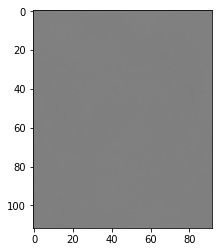

72
tensor([-0.0615], device='cuda:0')
tensor([-0.0615], device='cuda:0', grad_fn=<NegBackward>)


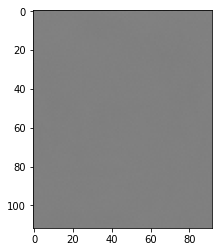

73
tensor([-0.0628], device='cuda:0')
tensor([-0.0628], device='cuda:0', grad_fn=<NegBackward>)


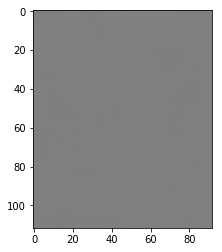

74
tensor([-0.0640], device='cuda:0')
tensor([-0.0640], device='cuda:0', grad_fn=<NegBackward>)


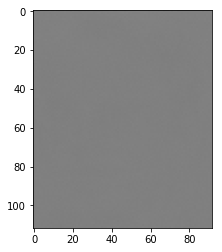

75
tensor([-0.0653], device='cuda:0')
tensor([-0.0653], device='cuda:0', grad_fn=<NegBackward>)


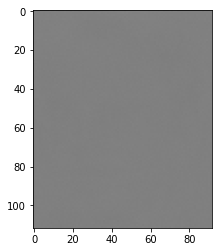

76
tensor([-0.0667], device='cuda:0')
tensor([-0.0667], device='cuda:0', grad_fn=<NegBackward>)


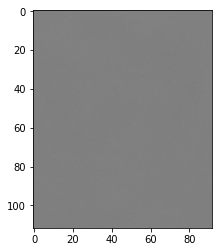

77
tensor([-0.0681], device='cuda:0')
tensor([-0.0681], device='cuda:0', grad_fn=<NegBackward>)


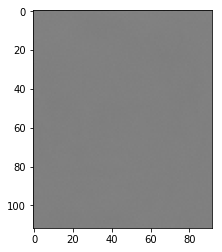

78
tensor([-0.0696], device='cuda:0')
tensor([-0.0696], device='cuda:0', grad_fn=<NegBackward>)


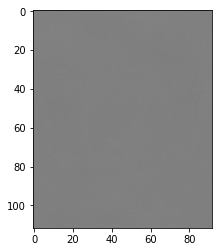

79
tensor([-0.0711], device='cuda:0')
tensor([-0.0711], device='cuda:0', grad_fn=<NegBackward>)


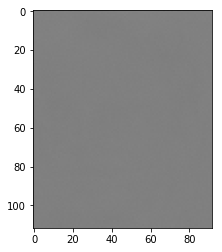

80
tensor([-0.0727], device='cuda:0')
tensor([-0.0727], device='cuda:0', grad_fn=<NegBackward>)


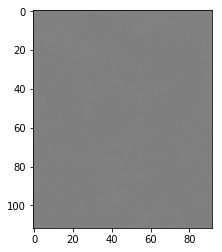

81
tensor([-0.0743], device='cuda:0')
tensor([-0.0743], device='cuda:0', grad_fn=<NegBackward>)


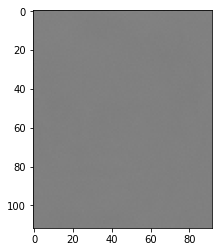

82
tensor([-0.0761], device='cuda:0')
tensor([-0.0761], device='cuda:0', grad_fn=<NegBackward>)


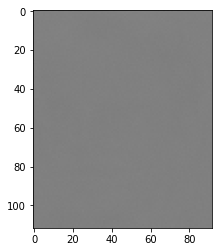

83
tensor([-0.0779], device='cuda:0')
tensor([-0.0779], device='cuda:0', grad_fn=<NegBackward>)


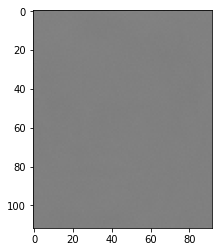

84
tensor([-0.0798], device='cuda:0')
tensor([-0.0798], device='cuda:0', grad_fn=<NegBackward>)


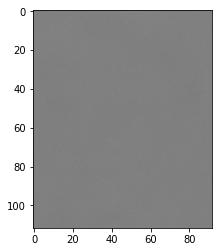

85
tensor([-0.0817], device='cuda:0')
tensor([-0.0817], device='cuda:0', grad_fn=<NegBackward>)


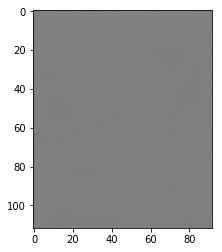

86
tensor([-0.0838], device='cuda:0')
tensor([-0.0838], device='cuda:0', grad_fn=<NegBackward>)


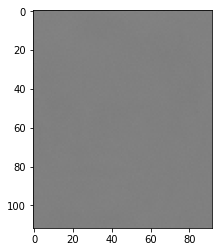

87
tensor([-0.0859], device='cuda:0')
tensor([-0.0859], device='cuda:0', grad_fn=<NegBackward>)


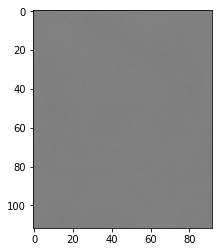

88
tensor([-0.0882], device='cuda:0')
tensor([-0.0882], device='cuda:0', grad_fn=<NegBackward>)


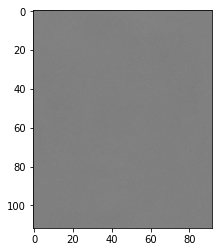

89
tensor([-0.0905], device='cuda:0')
tensor([-0.0905], device='cuda:0', grad_fn=<NegBackward>)


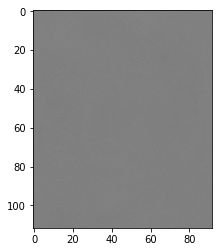

90
tensor([-0.0930], device='cuda:0')
tensor([-0.0930], device='cuda:0', grad_fn=<NegBackward>)


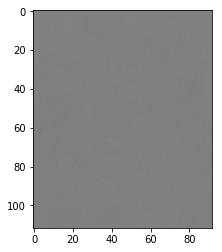

91
tensor([-0.0956], device='cuda:0')
tensor([-0.0956], device='cuda:0', grad_fn=<NegBackward>)


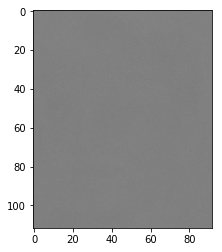

92
tensor([-0.0983], device='cuda:0')
tensor([-0.0983], device='cuda:0', grad_fn=<NegBackward>)


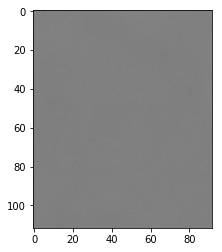

93
tensor([-0.1012], device='cuda:0')
tensor([-0.1012], device='cuda:0', grad_fn=<NegBackward>)


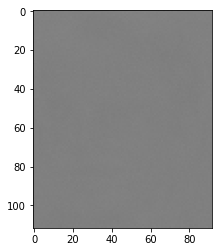

94
tensor([-0.1042], device='cuda:0')
tensor([-0.1042], device='cuda:0', grad_fn=<NegBackward>)


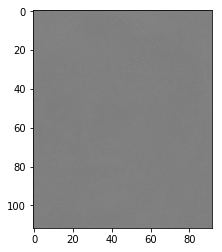

95
tensor([-0.1074], device='cuda:0')
tensor([-0.1074], device='cuda:0', grad_fn=<NegBackward>)


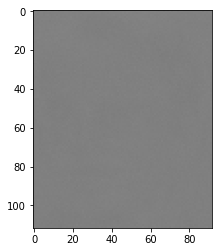

96
tensor([-0.1108], device='cuda:0')
tensor([-0.1108], device='cuda:0', grad_fn=<NegBackward>)


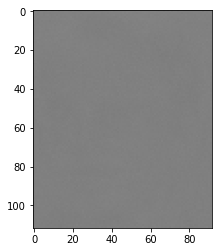

97
tensor([-0.1143], device='cuda:0')
tensor([-0.1143], device='cuda:0', grad_fn=<NegBackward>)


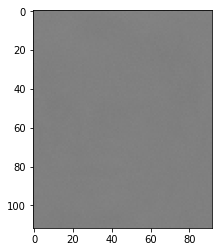

98
tensor([-0.1181], device='cuda:0')
tensor([-0.1181], device='cuda:0', grad_fn=<NegBackward>)


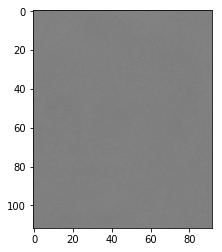

99
tensor([-0.1220], device='cuda:0')
tensor([-0.1220], device='cuda:0', grad_fn=<NegBackward>)


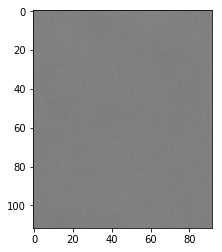

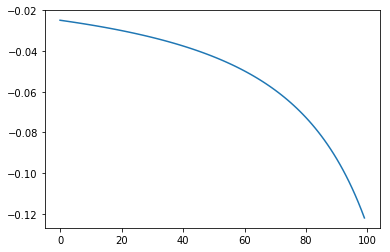

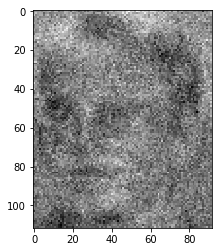

In [24]:
np_page=np.zeros((112,92))

dream_ga=ga_norm(torch.Tensor((np_page)),net2,100,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

## Auto-Encoder

Auto-encoder uses the target model as the encoder and inverts it to create the decoder. Overall reconstructs the same thing as GA but does it in 1 pass.

TODO: train decoder with shadow images.

In [81]:
print(ww.max(), ww.min())
noise = 0.01 * torch.randn(ww.shape).to(device) + 0.05
print(type(noise))
print(noise.max())
print(noise.min())
print(noise.shape)
ww = ww + noise
net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] + noise
print(ww)
print(net2.hidden1.weight.data[:])
print(ww == net2.hidden1.weight.data[:])

tensor(0.0991, device='cuda:0') tensor(-0.0813, device='cuda:0')
<class 'torch.Tensor'>
tensor(0.0971, device='cuda:0')
tensor(0.0046, device='cuda:0')
torch.Size([40, 10304])
tensor([[0.0154, 0.0369, 0.0436,  ..., 0.0307, 0.0349, 0.0619],
        [0.0706, 0.0534, 0.0587,  ..., 0.0363, 0.0275, 0.0406],
        [0.0388, 0.0326, 0.0167,  ..., 0.0239, 0.0662, 0.0272],
        ...,
        [0.0427, 0.0722, 0.0363,  ..., 0.0591, 0.0810, 0.0422],
        [0.0845, 0.0478, 0.0611,  ..., 0.0595, 0.0599, 0.0374],
        [0.0559, 0.0567, 0.0778,  ..., 0.0332, 0.0621, 0.0489]],
       device='cuda:0')
tensor([[0.0154, 0.0369, 0.0436,  ..., 0.0307, 0.0349, 0.0619],
        [0.0706, 0.0534, 0.0587,  ..., 0.0363, 0.0275, 0.0406],
        [0.0388, 0.0326, 0.0167,  ..., 0.0239, 0.0662, 0.0272],
        ...,
        [0.0427, 0.0722, 0.0363,  ..., 0.0591, 0.0810, 0.0422],
        [0.0845, 0.0478, 0.0611,  ..., 0.0595, 0.0599, 0.0374],
        [0.0559, 0.0567, 0.0778,  ..., 0.0332, 0.0621, 0.0489]],
    

In [82]:
class ae(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=3000): 
        super(ae, self).__init__()
        
        self.hidden1 = nn.Linear(n_in, n_out)        
        self.hidden2 = nn.Linear(n_out, n_in)
    def forward(self, x):
        x = x.view(-1,112*92)

        x = self.hidden1(x)
        out = self.hidden2(x)
        
        return out
    
class de(nn.Module): 
    def __init__(self, n_in=40, n_out=112*92, n_hidden=3000): 
        super(de, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_out)        
        
    def forward(self, x):
        x = x.view(-1,40)
        out = self.hidden1(x)
        
        return out

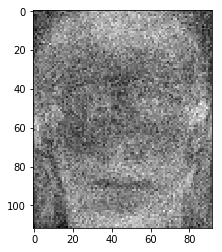

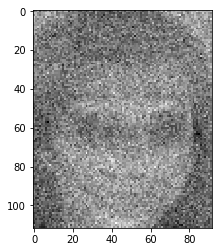

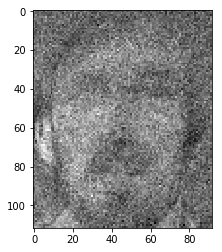

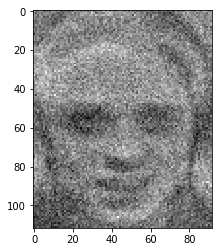

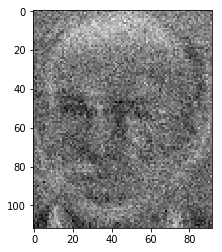

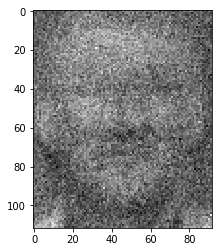

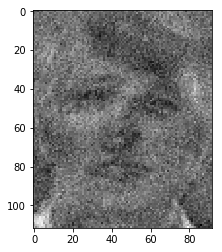

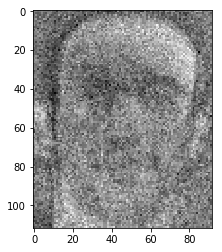

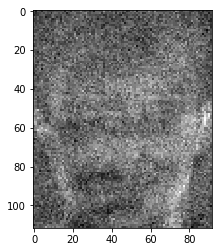

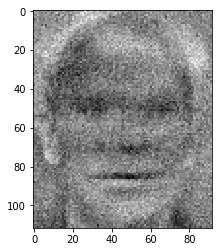

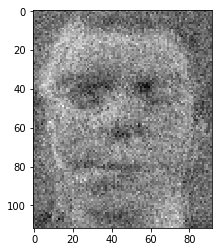

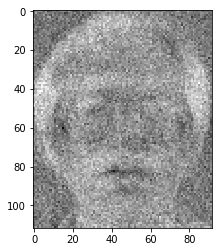

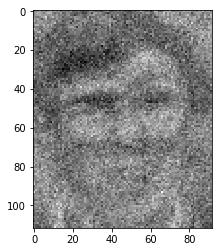

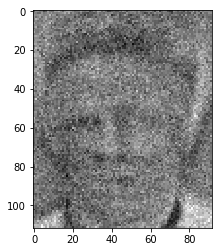

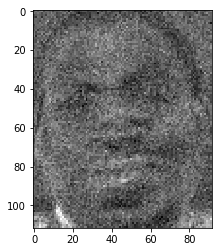

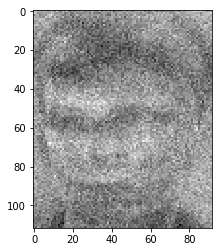

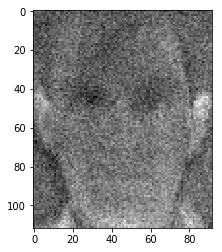

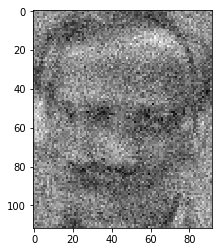

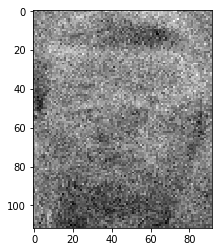

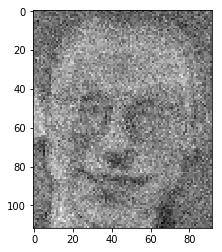

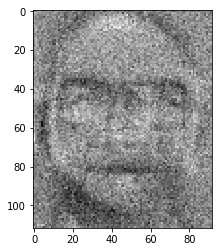

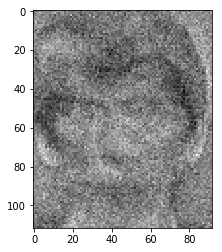

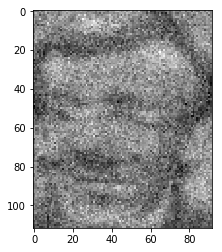

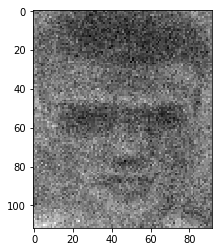

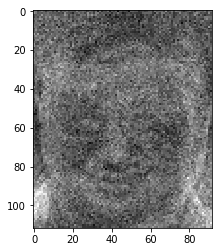

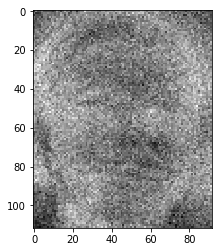

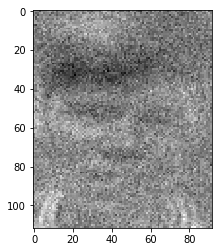

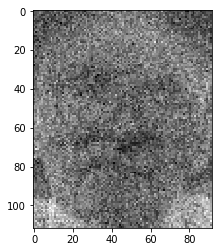

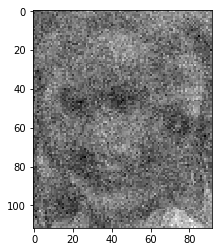

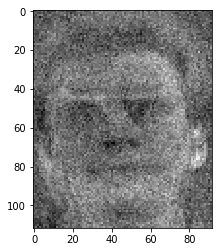

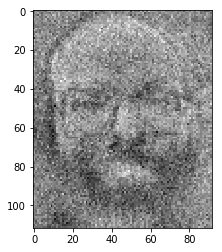

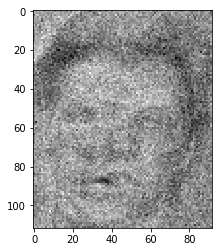

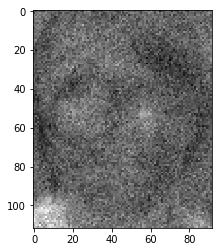

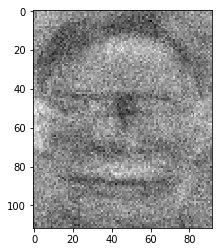

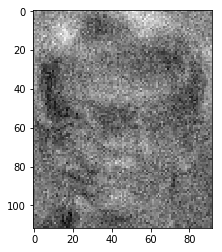

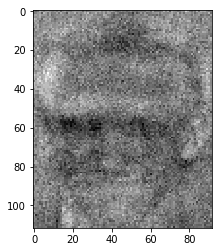

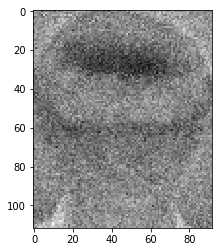

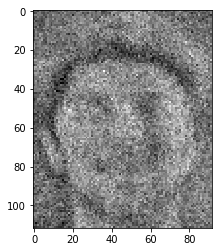

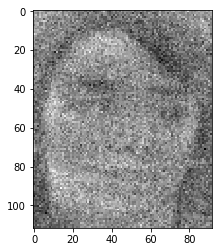

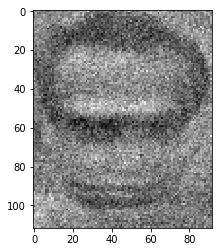

In [83]:
netAE = ae().to(device)
netDE = de().to(device)
ainv = np.linalg.pinv(net2.hidden1.weight.data.squeeze().cpu().detach().numpy())

netAE.hidden1.weight.data = net2.hidden1.weight.data
netAE.hidden2.weight.data = torch.tensor(ainv).to(device)
netDE.hidden1.weight.data = torch.tensor(ainv).to(device)

netAE.hidden1.bias.data = torch.tensor(0.0).to(device)
netAE.hidden2.bias.data = torch.tensor(0.0).to(device)
netDE.hidden1.bias.data = torch.tensor(0.0).to(device)

ww = net2.hidden1.weight.data
bb = net2.hidden1.bias.data

for i in range(40):
    im = ww[i,:].squeeze().cpu().detach().numpy().reshape(112,92)
    imAE = netAE(ww[i,:].to(device))
    label = torch.zeros(40)
    label[i]=1
    imDE = netDE(label.to(device))
#     plt.imshow(imDE.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
#     plt.show()
    tmp = imAE.squeeze().cpu().detach().numpy().reshape(112,92)-ww0[i,:].squeeze().cpu().detach().numpy().reshape(112,92)
    plt.imshow(tmp,cmap='gray')
    plt.imsave('.\\ae\\{0}'.format(idx_to_people[i]), tmp,cmap='gray')
    plt.show()


<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> torch.Size([4, 572, 754])
<class 'numpy.ndarray'> (4, 572, 754)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])
tensor(0.)
tensor(1.)
torch.Size([40, 4, 112, 92])


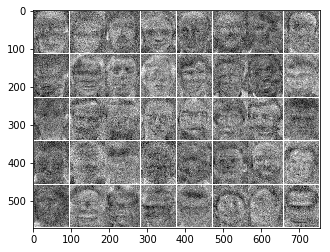

In [84]:
class MLPdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        data = np.asarray(img)
        label = people_to_idx[img_path.split('\\')[-1].split('.')[-2]]
        if self.transform is not None: 
            img = self.transform(img)
        
        return img, label

mlp_dir = ".\\ae\\"

mlp_paths = []
for p in os.listdir(mlp_dir): 
    mlp_paths.append(os.path.join(mlp_dir,p))
        
mlpset = MLPdataset(mlp_paths, people_to_idx, transform=torchvision.transforms.ToTensor())
mlploader = torch.utils.data.DataLoader(mlpset, batch_size=40, shuffle=False, num_workers=0)

mlp_imgs,labels = iter(mlploader).next()
print(type(mlp_imgs), type(torchvision.utils.make_grid(mlp_imgs)))
imshow(torchvision.utils.make_grid(mlp_imgs), 'ae') 
print(labels)
print(mlp_imgs.min())
print(mlp_imgs.max())
print(mlp_imgs.shape)

In [85]:
ww = ww - noise
net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] - noise
print(ww, net2.hidden1.weight.data[:])

tensor([[-0.0306, -0.0153, -0.0047,  ..., -0.0318, -0.0105,  0.0056],
        [ 0.0348,  0.0121,  0.0042,  ..., -0.0196, -0.0135, -0.0074],
        [-0.0310, -0.0172, -0.0275,  ..., -0.0156,  0.0093, -0.0286],
        ...,
        [-0.0070,  0.0233, -0.0040,  ...,  0.0165,  0.0338,  0.0016],
        [ 0.0267, -0.0057,  0.0103,  ...,  0.0135,  0.0132, -0.0075],
        [-0.0029,  0.0039,  0.0154,  ..., -0.0047,  0.0081,  0.0048]],
       device='cuda:0') tensor([[-0.0306, -0.0153, -0.0047,  ..., -0.0318, -0.0105,  0.0056],
        [ 0.0348,  0.0121,  0.0042,  ..., -0.0196, -0.0135, -0.0074],
        [-0.0310, -0.0172, -0.0275,  ..., -0.0156,  0.0093, -0.0286],
        ...,
        [-0.0070,  0.0233, -0.0040,  ...,  0.0165,  0.0338,  0.0016],
        [ 0.0267, -0.0057,  0.0103,  ...,  0.0135,  0.0132, -0.0075],
        [-0.0029,  0.0039,  0.0154,  ..., -0.0047,  0.0081,  0.0048]],
       device='cuda:0')


## Posterior Averaging

Posterior averaging works by taking a weighted average of a sample of images weghing it by the posterior activation of a particular category. 
Works well but depends on the information that you already have in your sample images

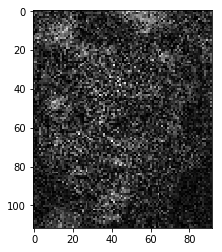

In [28]:
out_sum = torch.cuda.FloatTensor(np.zeros((1,112,92)))
n = torch.cuda.FloatTensor(np.zeros((1)))
# for j in range(100):
for i, batch in enumerate(testloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)

    out = nn.functional.softmax(net2(imgs), dim = 1 )
    out_im=(imgs*torch.tensor(np.abs(im)).to(device))

    out_sum =  (out_sum * n + torch.sum(out_im*out[:,34].view(-1,1,1,1),dim=0)) / (n + (imgs.size()[0]))
    n = n + (imgs.size()[0])
plt.imshow(out_sum.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

You can also just use the weighted average of the sample images weighted by the posterior probablity and not including the activation weighting. This works better for good sample images.

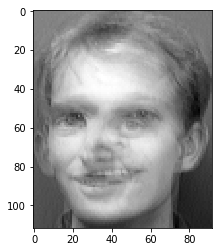

In [29]:

out_sum = torch.cuda.FloatTensor(np.zeros((1,112,92)))
n = torch.cuda.FloatTensor(np.zeros((1)))
# for j in range(100):
for i, batch in enumerate(testloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)

    out = nn.functional.softmax(net2(imgs), dim = 1 )
    out_im=(imgs).to(device)

    out_sum =  (out_sum * n + torch.sum(out_im*out[:,34].view(-1,1,1,1),dim=0)) / (n + (imgs.size()[0]))
    n = n + (imgs.size()[0])
plt.imshow(out_sum.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

## Student-teacher

In [30]:
student = mlp().to(device)
student.apply(models.weights_init)

ww_student = copy.deepcopy(student.hidden1.weight.data)
bb_student = copy.deepcopy(student.hidden1.bias.data[:])
im_student = ww_student[34].reshape(112,92)

criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student.parameters(), lr=lr/10)

In [31]:
def train_student(student, teacher, data_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
    losses = []
    train_accuracy = []
        
    for epoch in range(n_epochs):
        student.train()
        teacher.eval()
        net2.hidden1.weight.requires_grad=False
        total = 0
        correct = 0
        for i, batch in enumerate(data_loader):

            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            
#             imgs = torch.randn(imgs.size()).to(device)
#             im = torch.zeros(imgs.size())
#             for i in range(imgs.size(0)):
#                 imgs[i,0,:,:] = tensorBlur(imgs[i,:,:,:].squeeze(),15)
            optimizer.zero_grad()

            outputs = student(imgs)
            output_teacher = teacher(imgs).detach()
            
            ## accuracy calc
            predicted = outputs.argmax(dim=1)
            total += imgs.size(0)
            correct += predicted.eq(labels).sum().item()
            ##

#             loss = criterion(outputs, labels)
            loss = criterion(outputs, output_teacher)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if verbose:
                print("[%d/%d][%d/%d] loss = %f" % (epoch, n_epochs, i, len(data_loader), loss.item()))

        # evaluate performance on testset at the end of each epoch
        print("[%d/%d]" %(epoch, n_epochs))
#         train_accuracy.append(eval_target_net(net, data_loader, classes=classes))
        train_accuracy.append(correct/total*100)
#         test_accuracy.append(eval_target_net(net, test_loader, classes=classes))
        print("Train Accuracy %f" %(correct/total*100))
#         print(train_accuracy)
#         plt.plot(train_accuracy,'bo-',label="train accuracy")
        plt.plot(losses,'bo-',label="losses")
#         plt.plot(test_accuracy,'ro-',label="validation accuracy")
        
        # Place a legend to the right of this smaller subplot.
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        plt.show()

[0/100]
Train Accuracy 5.000000


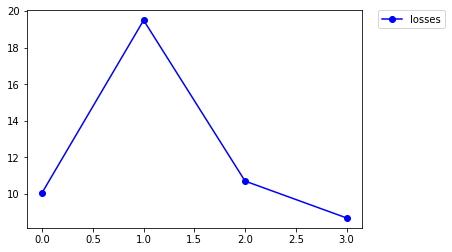

[1/100]
Train Accuracy 6.666667


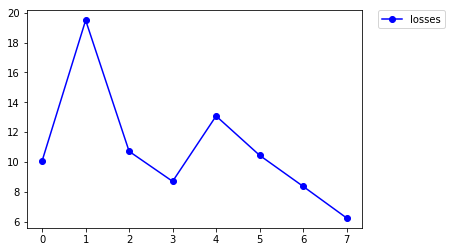

[2/100]
Train Accuracy 15.833333


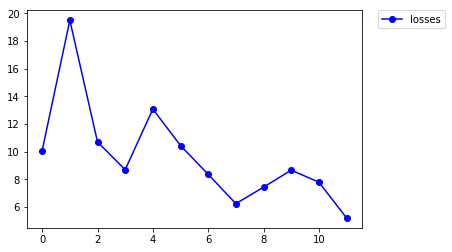

[3/100]
Train Accuracy 29.166667


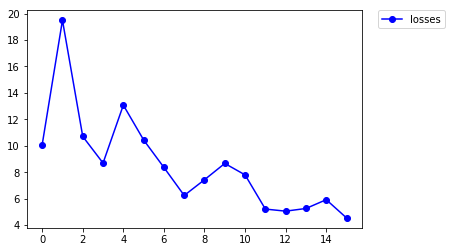

[4/100]
Train Accuracy 35.833333


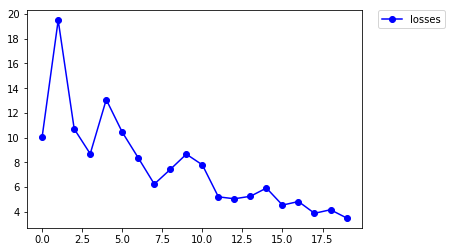

[5/100]
Train Accuracy 55.000000


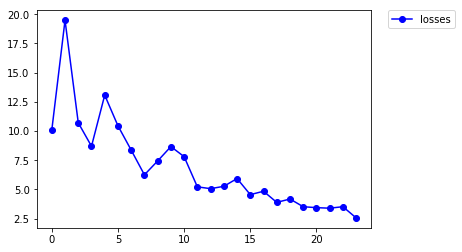

[6/100]
Train Accuracy 46.666667


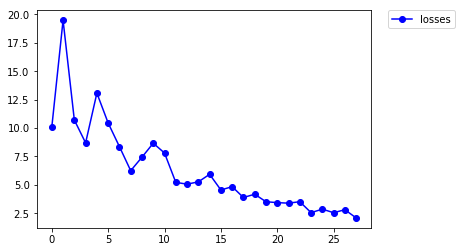

[7/100]
Train Accuracy 62.500000


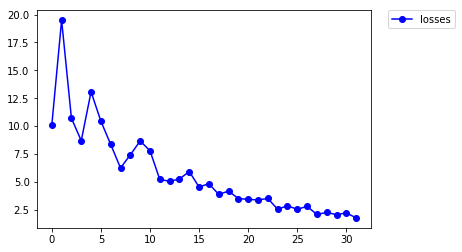

[8/100]
Train Accuracy 66.666667


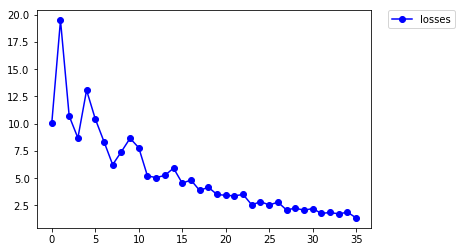

[9/100]
Train Accuracy 70.833333


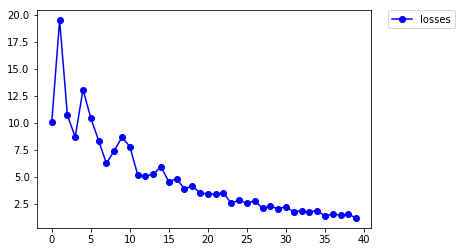

[10/100]
Train Accuracy 80.833333


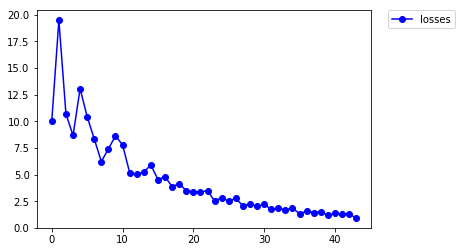

[11/100]
Train Accuracy 80.833333


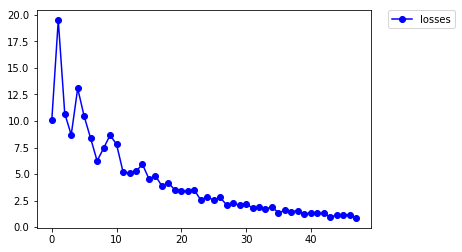

[12/100]
Train Accuracy 82.500000


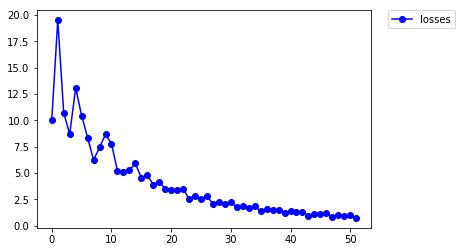

[13/100]
Train Accuracy 84.166667


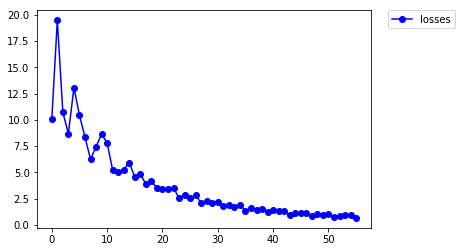

[14/100]
Train Accuracy 87.500000


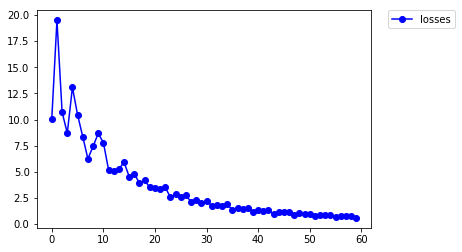

[15/100]
Train Accuracy 90.000000


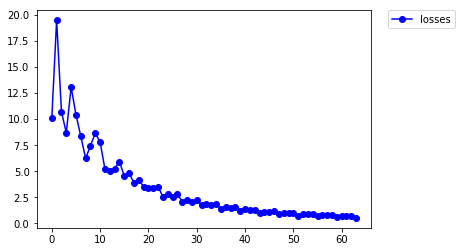

[16/100]
Train Accuracy 92.500000


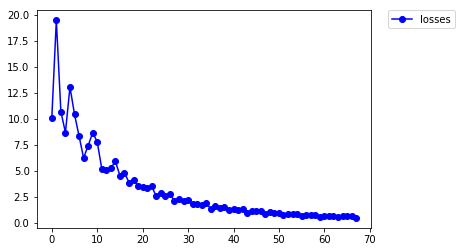

[17/100]
Train Accuracy 93.333333


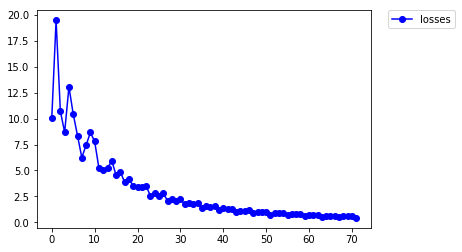

[18/100]
Train Accuracy 93.333333


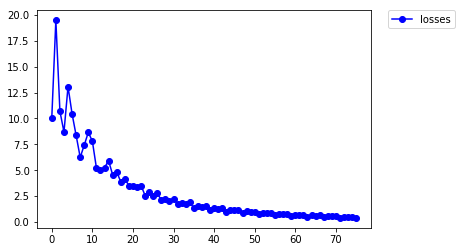

[19/100]
Train Accuracy 94.166667


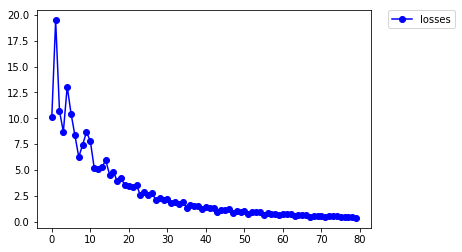

[20/100]
Train Accuracy 94.166667


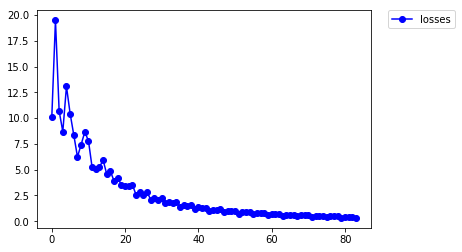

[21/100]
Train Accuracy 94.166667


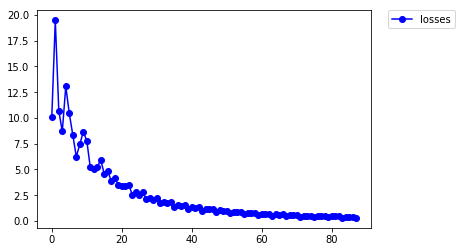

[22/100]
Train Accuracy 94.166667


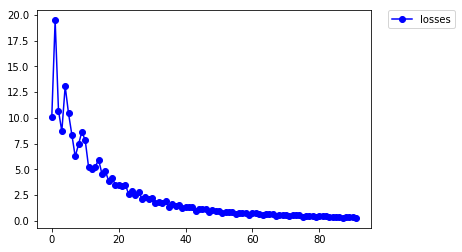

[23/100]
Train Accuracy 94.166667


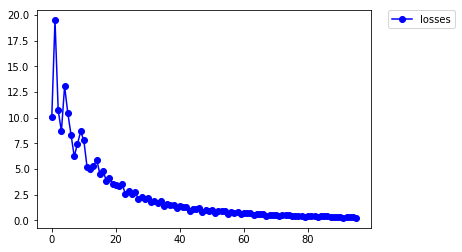

[24/100]
Train Accuracy 94.166667


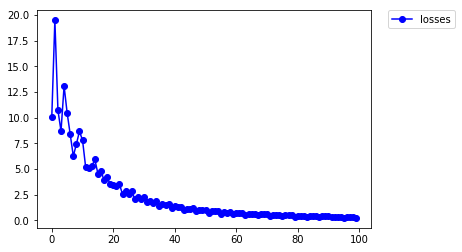

[25/100]
Train Accuracy 94.166667


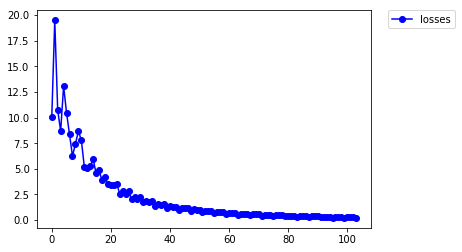

[26/100]
Train Accuracy 94.166667


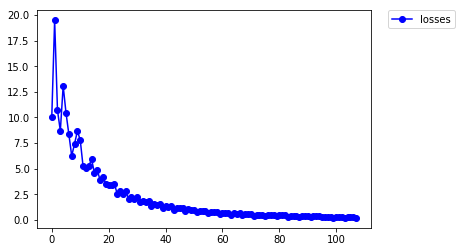

[27/100]
Train Accuracy 95.000000


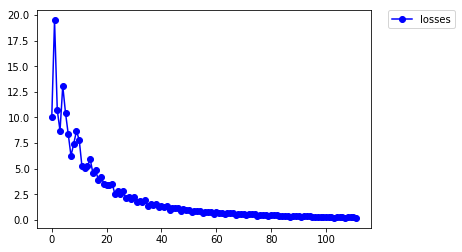

[28/100]
Train Accuracy 95.000000


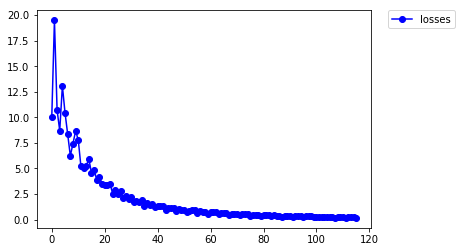

[29/100]
Train Accuracy 95.000000


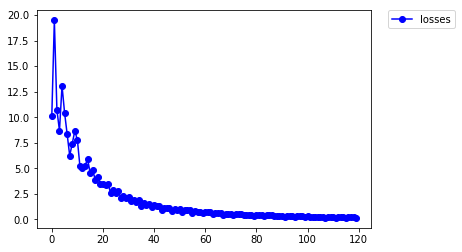

[30/100]
Train Accuracy 95.000000


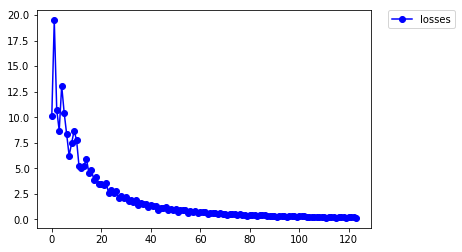

[31/100]
Train Accuracy 95.000000


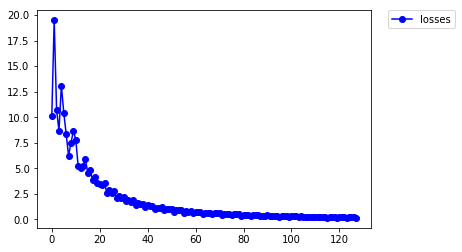

[32/100]
Train Accuracy 95.000000


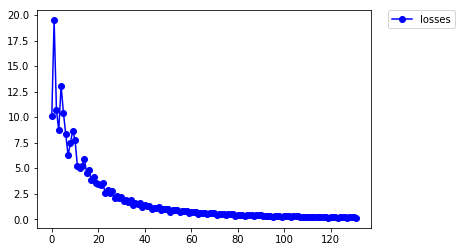

[33/100]
Train Accuracy 95.000000


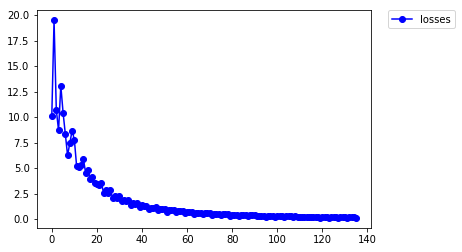

[34/100]
Train Accuracy 95.000000


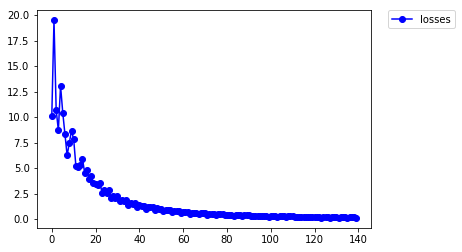

[35/100]
Train Accuracy 95.000000


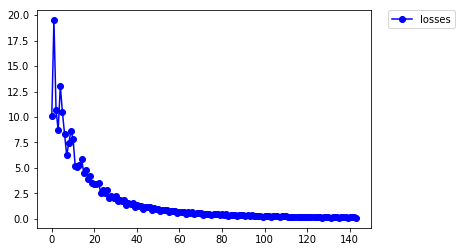

[36/100]
Train Accuracy 95.000000


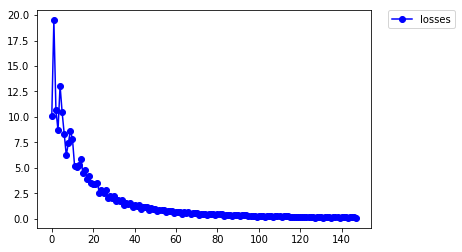

[37/100]
Train Accuracy 95.000000


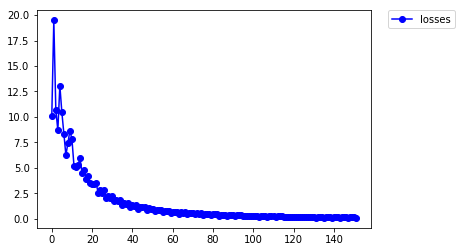

[38/100]
Train Accuracy 95.000000


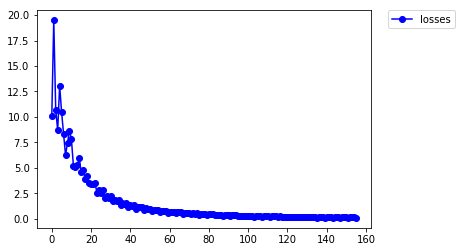

[39/100]
Train Accuracy 95.000000


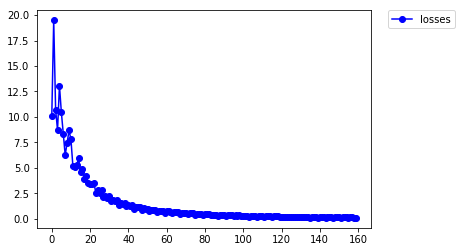

[40/100]
Train Accuracy 95.833333


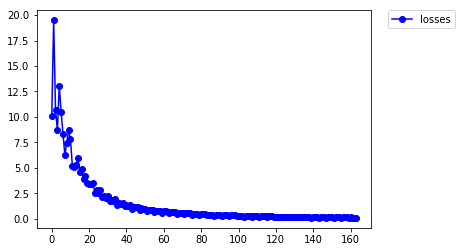

[41/100]
Train Accuracy 95.833333


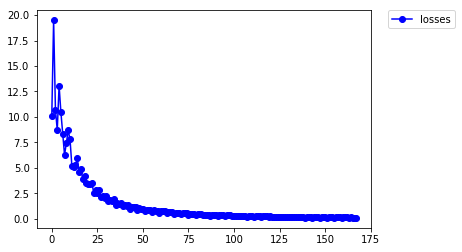

[42/100]
Train Accuracy 95.833333


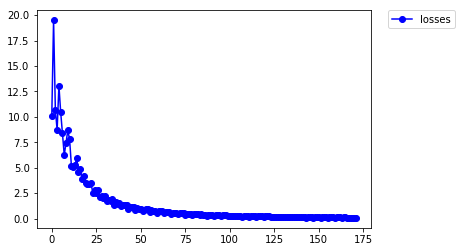

[43/100]
Train Accuracy 95.833333


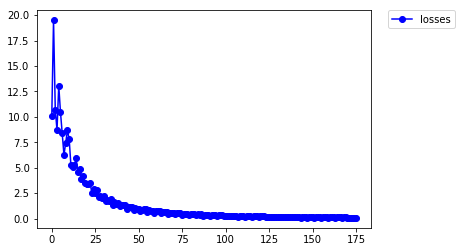

[44/100]
Train Accuracy 95.833333


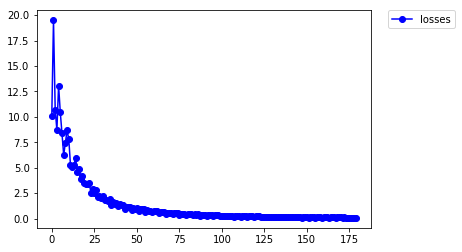

[45/100]
Train Accuracy 95.833333


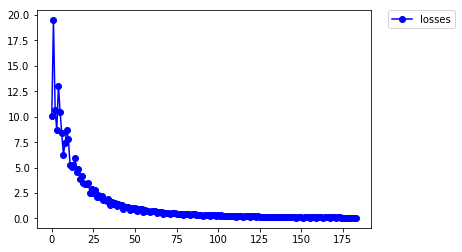

[46/100]
Train Accuracy 95.833333


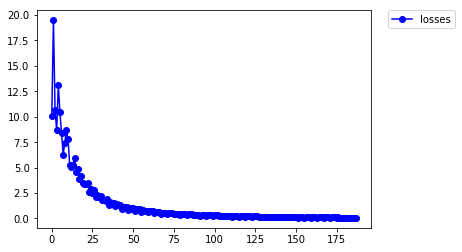

[47/100]
Train Accuracy 95.833333


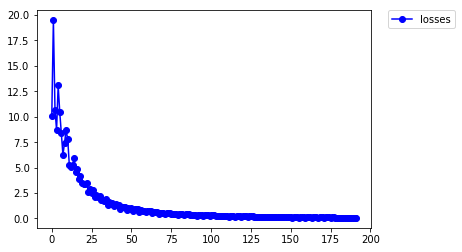

[48/100]
Train Accuracy 95.833333


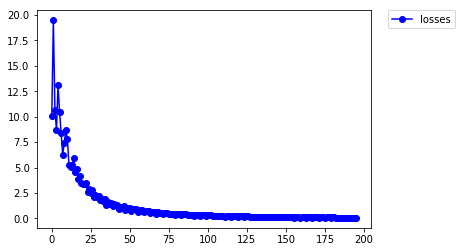

[49/100]
Train Accuracy 95.833333


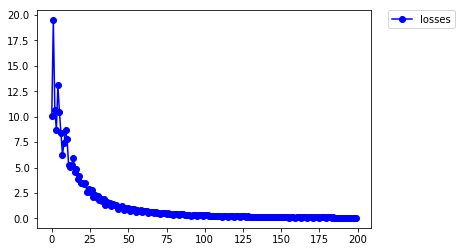

[50/100]
Train Accuracy 95.833333


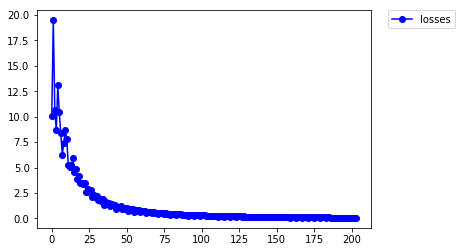

[51/100]
Train Accuracy 95.833333


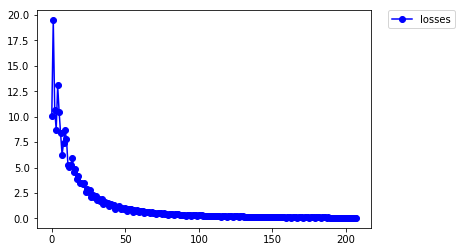

[52/100]
Train Accuracy 95.833333


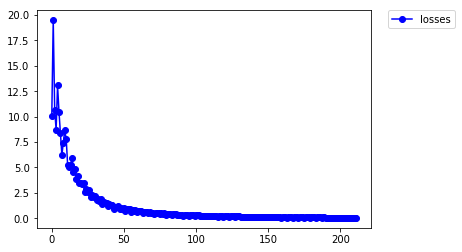

[53/100]
Train Accuracy 95.833333


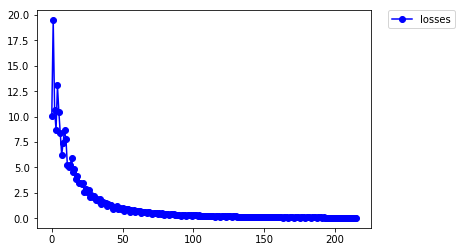

[54/100]
Train Accuracy 95.833333


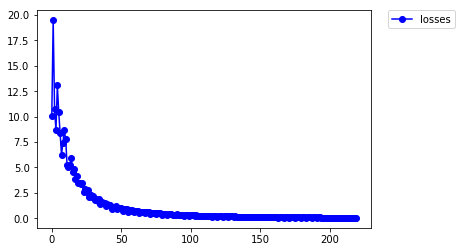

[55/100]
Train Accuracy 95.833333


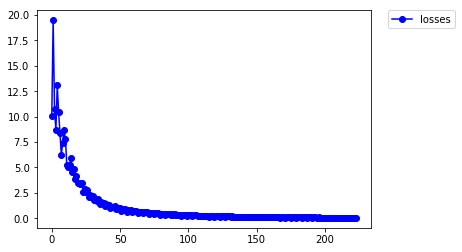

[56/100]
Train Accuracy 95.833333


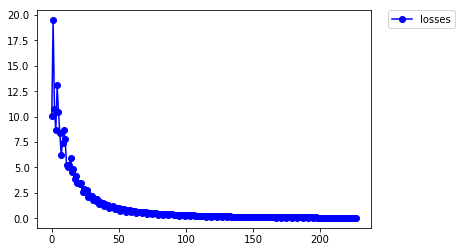

[57/100]
Train Accuracy 95.833333


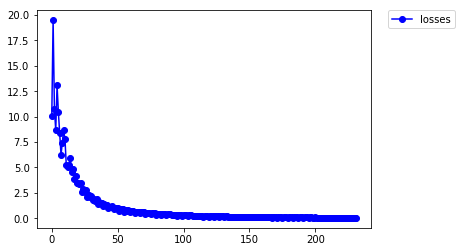

[58/100]
Train Accuracy 95.833333


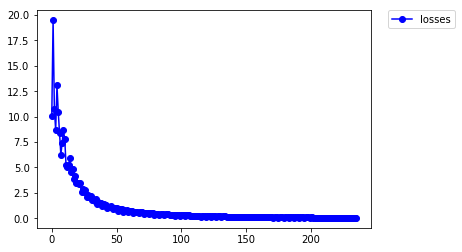

[59/100]
Train Accuracy 95.833333


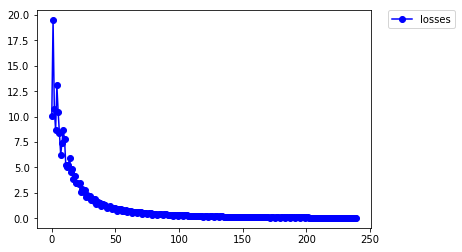

[60/100]
Train Accuracy 95.833333


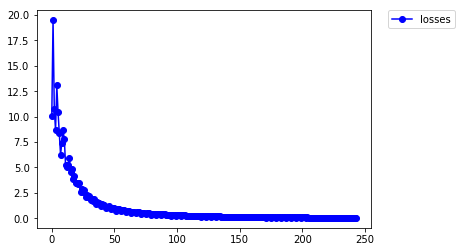

[61/100]
Train Accuracy 95.833333


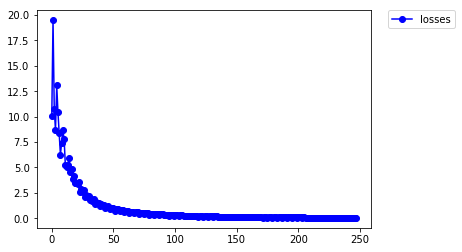

[62/100]
Train Accuracy 95.833333


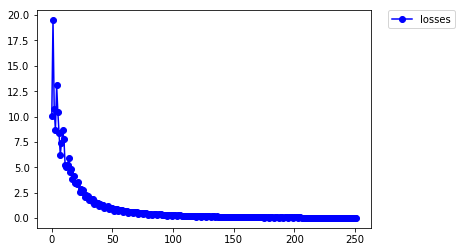

[63/100]
Train Accuracy 95.833333


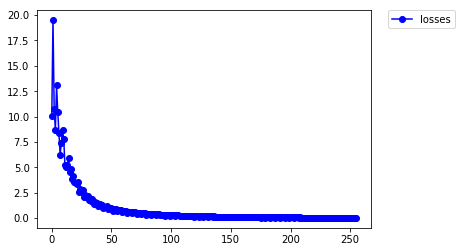

[64/100]
Train Accuracy 95.833333


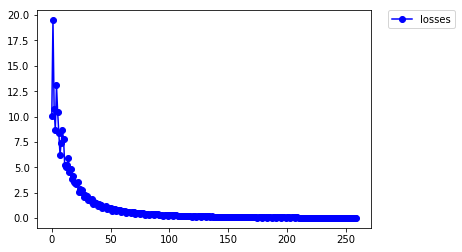

[65/100]
Train Accuracy 95.833333


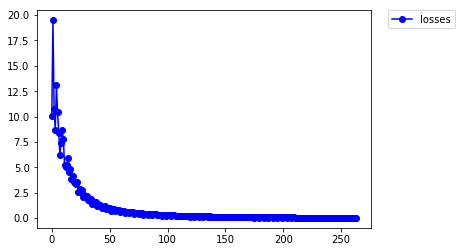

[66/100]
Train Accuracy 95.833333


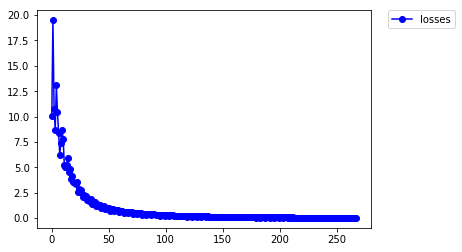

[67/100]
Train Accuracy 95.833333


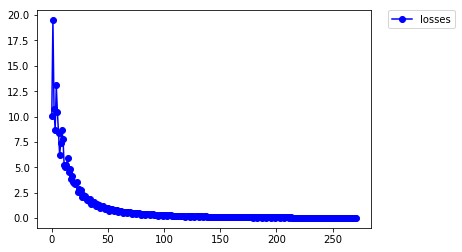

[68/100]
Train Accuracy 95.833333


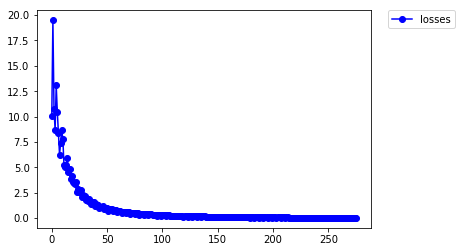

[69/100]
Train Accuracy 95.833333


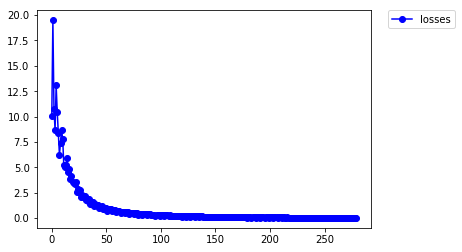

[70/100]
Train Accuracy 95.833333


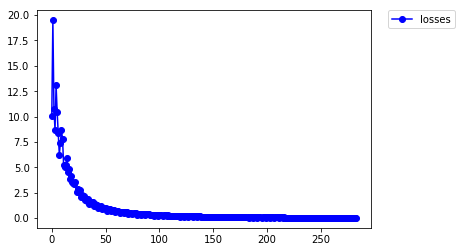

[71/100]
Train Accuracy 95.833333


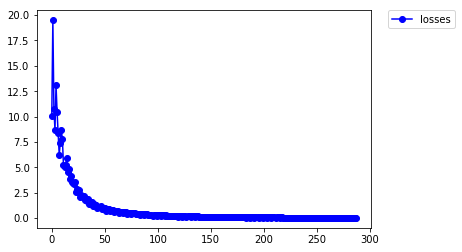

[72/100]
Train Accuracy 95.833333


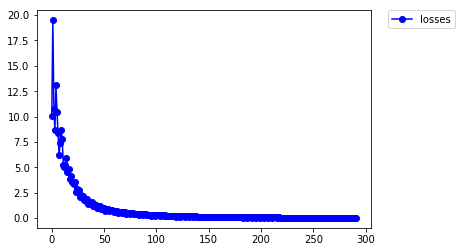

[73/100]
Train Accuracy 95.833333


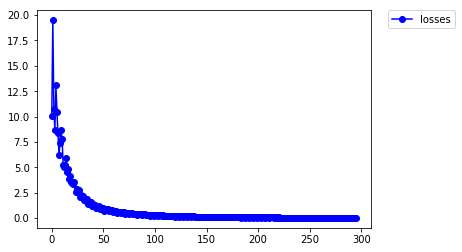

[74/100]
Train Accuracy 95.833333


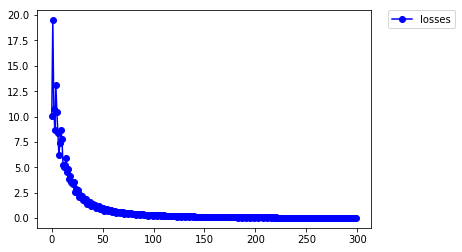

[75/100]
Train Accuracy 95.833333


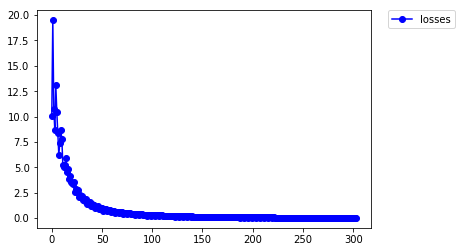

[76/100]
Train Accuracy 95.833333


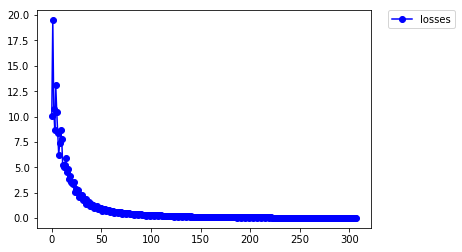

[77/100]
Train Accuracy 95.833333


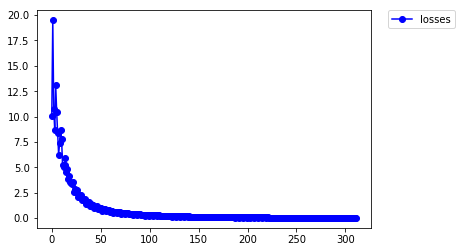

[78/100]
Train Accuracy 95.833333


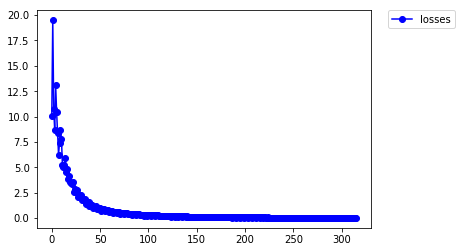

[79/100]
Train Accuracy 95.833333


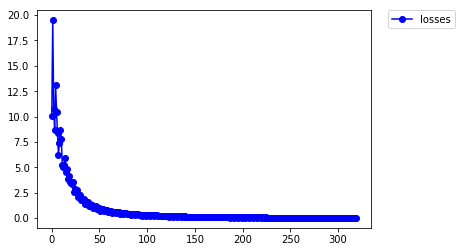

[80/100]
Train Accuracy 95.833333


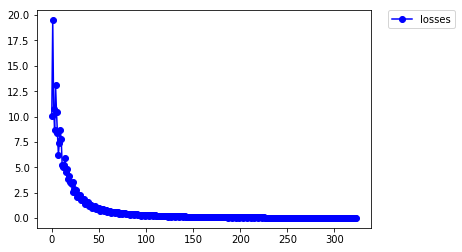

[81/100]
Train Accuracy 95.833333


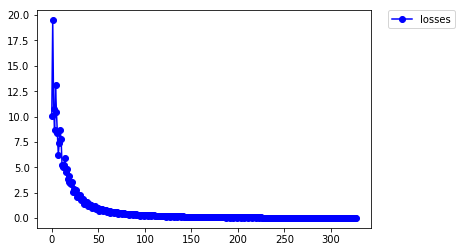

[82/100]
Train Accuracy 95.833333


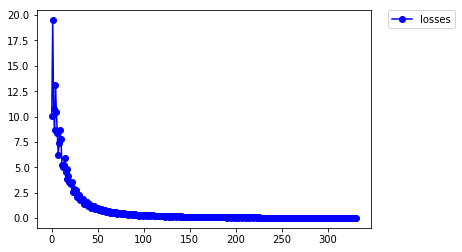

[83/100]
Train Accuracy 95.833333


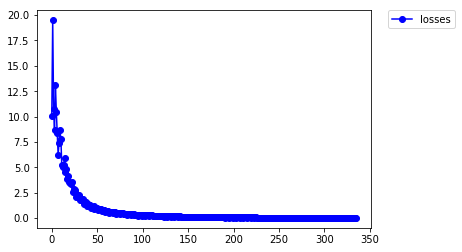

[84/100]
Train Accuracy 95.833333


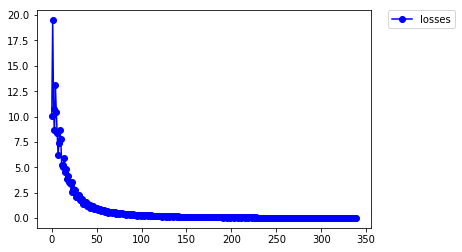

[85/100]
Train Accuracy 95.833333


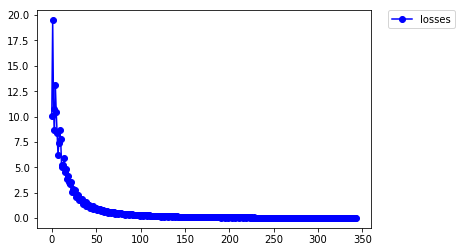

[86/100]
Train Accuracy 95.833333


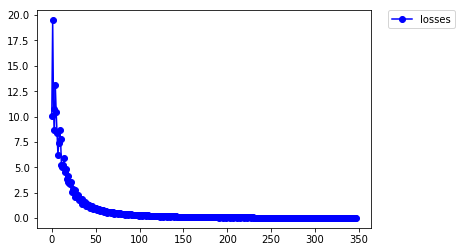

[87/100]
Train Accuracy 95.833333


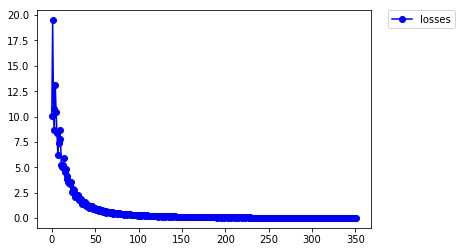

[88/100]
Train Accuracy 95.833333


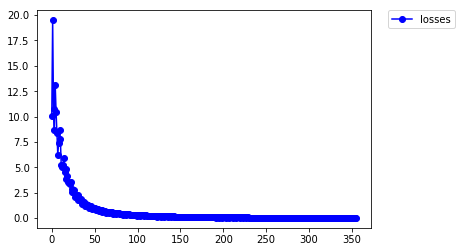

[89/100]
Train Accuracy 95.833333


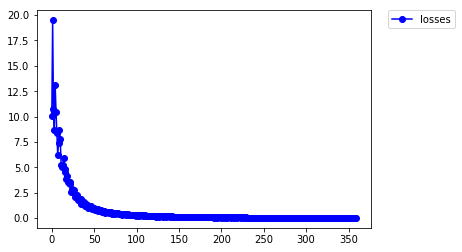

[90/100]
Train Accuracy 95.833333


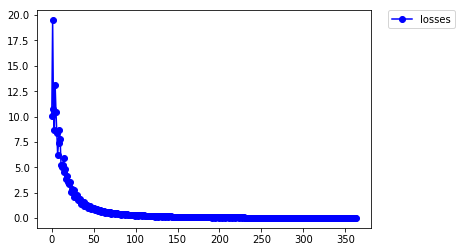

[91/100]
Train Accuracy 95.833333


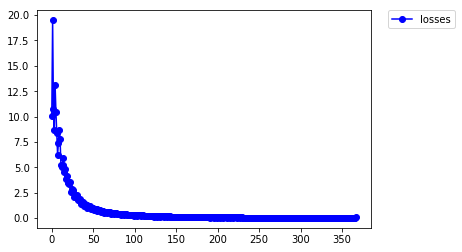

[92/100]
Train Accuracy 95.833333


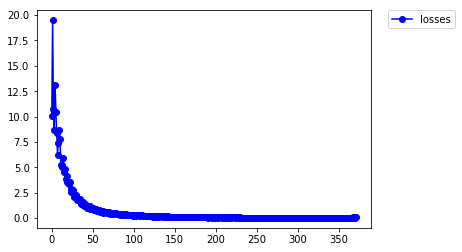

[93/100]
Train Accuracy 95.833333


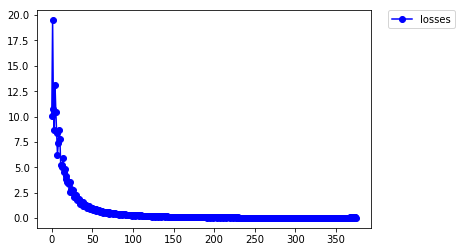

[94/100]
Train Accuracy 95.833333


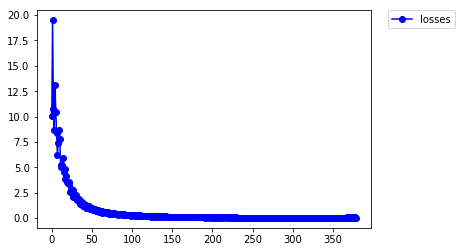

[95/100]
Train Accuracy 95.833333


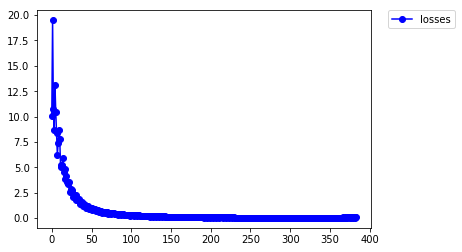

[96/100]
Train Accuracy 95.833333


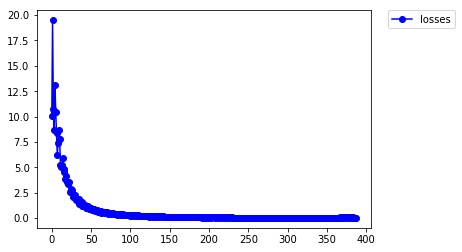

[97/100]
Train Accuracy 95.833333


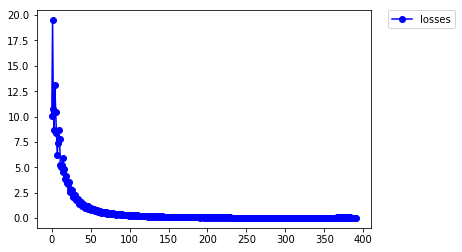

[98/100]
Train Accuracy 95.833333


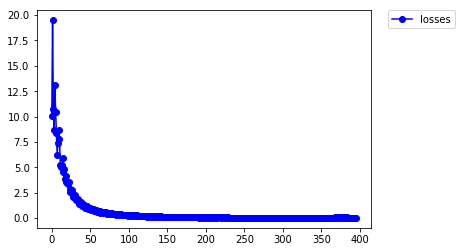

[99/100]
Train Accuracy 95.833333


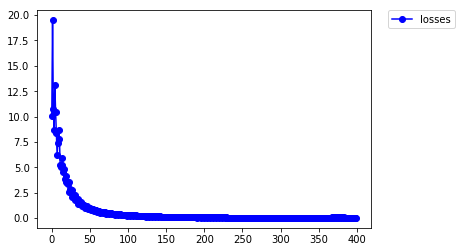

In [32]:
train_student(student, net2, testloader, optimizer_student, criterion, n_epochs=100, verbose=False)

Attack student with an attack we know works well on the student training/architecture. In this case we will use gradient ascent.


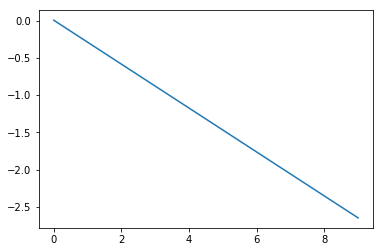

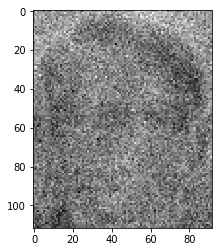

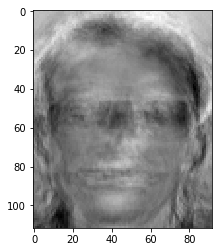

In [34]:
np_page=np.zeros((112,92))

dream_ga=ga(torch.Tensor((np_page)),student,10,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im_student.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [35]:
eval_target_net(net, testloader)


Accuracy = 92.50 %




92.5

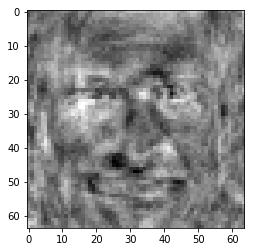

In [30]:
# net2.hidden1.weight.data = ww - ww0
net2.hidden1.bias.data = torch.tensor(0.0).to(device)
ww_net = copy.deepcopy(net2.hidden1.weight.data)
# bb_net = copy.deepcopy(net.hidden1.bias.data[:])x
im_net = ww_net[0].reshape(64,64)
plt.imshow(im_net.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [31]:
print(labels.eq(0).sum())
print(out[:,0].sum())

tensor(0, device='cuda:0')
tensor(0.1203, device='cuda:0', grad_fn=<SumBackward0>)


<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', dtype=torch.float64)
torch.Size([24])
tensor([3.4658], device='cuda:0', grad_fn=<AddBackward0>)


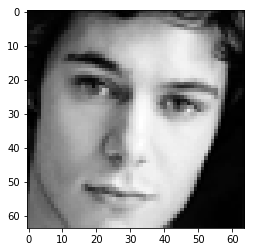

In [45]:
# testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)
out_sum = torch.cuda.FloatTensor(np.zeros((24)))
n = torch.cuda.FloatTensor(np.zeros((1)))
category = 1
for i, batch in enumerate(trainloader):

    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)
    
    out = nn.functional.softmax(net2(imgs), dim = 1 )    
    outputs = net2(imgs)
    out_sum = out_sum + ((out[:,category]>.5).float().view(-1,1)*outputs).sum(0)
    n = n + out[:,category].sum()

    if i ==0:
        break
# for i, batch in enumerate(testloader):

#     imgs, labels = batch
#     imgs, labels = imgs.to(device), labels.to(device)
    
#     out = nn.functional.softmax(net2(imgs), dim = 1 )    
#     outputs = net2(imgs)
#     out_sum = out_sum + ((out[:,category]>.5).float().view(-1,1)*outputs).sum(0)
#     n = n + out[:,category].sum()
print(type(labels==category))
print(type((labels==category).double()))
tmpt = (labels==category).double()
print(tmpt)
plt.imshow(imgs[tmpt.argmax(),:,:].squeeze().cpu(),cmap = 'gray')
outputs.argmax(1)
print(out_sum.size())
print(n)

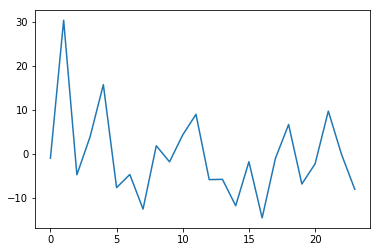

In [46]:
plt.plot(out_sum.cpu().detach().numpy())
plt.show()

In [47]:
def tensorRight(im):
    
    pad_filter = nn.ReflectionPad2d(1)
    gaussian_filter = nn.Conv2d(1, 1, 3,
                                stride = 1, bias=False, padding= 0)

    gaussian_filter.weight.data = torch.tensor([[0.0, 0.0, 0.0],[0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]).cuda().view(1,1,kernel_size,kernel_size)
    
    gaussian_filter.to(device)
    pad_filter.to(device)
    
    out = gaussian_filter(pad_filter(im))
    return out

def tensorDown(im):
    pad_filter = nn.ReflectionPad2d(1)
    gaussian_filter = nn.Conv2d(1, 1, 3,
                                stride = 1, bias=False, padding= 0)

    gaussian_filter.weight.data = torch.tensor([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0], [0.0, 1.0, 0.0]]).cuda().view(1,1,kernel_size,kernel_size)
    
    gaussian_filter.to(device)
    pad_filter.to(device)

    out = gaussian_filter(pad_filter(im))
    return out
def TV(im):
    im_right = tensorRight(im)
    im_down = tensorDown(im)
    TV_fd = (im - im_right)**2 + (im - im_down)**2
    return TV_fd.sum()

In [48]:
from torch.autograd import Variable
def ga_feature(image, net, iterations, lr,category,discriminator,alpha):        
#     category = Variable(torch.cuda([category]))
    category = torch.tensor(category).to(device).detach().unsqueeze(0)
    loss_fn = nn.MSELoss()
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses = []
    loss = 20
    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            discriminator.zero_grad()
            out = net(input)
#             print(input.size())
            out2 = discriminator(input.unsqueeze(0))
#             print(input.size())
            loss = loss_fn(out, category) + out2*alpha#+ TV(input.unsqueeze(0))*1/(1+j/alpha)
            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        losses.append(loss.data)
#     plt.plot(losses)
#     plt.show()
    input = input.detach()
    return input



def ga2(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses = []
    
    for j in range(iterations):
        for i in range(1):
            net.zero_grad()           
            out = net(input)
            loss= -out.take(category)            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        losses.append(loss.data)
        

    plt.plot(losses)
    plt.show()
    return input

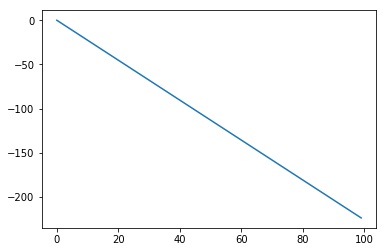

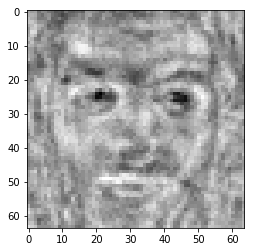

In [49]:
np_page=np.zeros((64,64))
dream_ga=ga2(torch.Tensor((np_page)),net2,100,1e-1,category)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

In [51]:
# np_page=torch.rand((112,92))
np_page=torch.zeros((64,64))
# im00 = imgs[(labels==0).argmax(),:,:].squeeze().cpu()
# np_page = torch.tensor(im00)

dream_ga=ga_feature(np_page,net2,1000,1e-1,out_sum/n,1)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')


TypeError: ga_feature() missing 1 required positional argument: 'alpha'

In [52]:
class disc_model(nn.Module):    
    def __init__(self, n_out = 1):
        super(disc_model,self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.full_connected = nn.Sequential(
            nn.Linear(64*28*23,200),
            nn.LeakyReLU(),
            nn.Linear(200, n_out),
#             nn.Softmax()
        )
    def forward(self, x):
        b_size = x.shape[0]
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
#         print(x.size())
        x = self.full_connected(x.view(b_size,64*28*23))
        x = F.sigmoid(x)
        return x
    
# class disc_model(nn.Module):
#     def __init__(self,num_classes = 10):
#         super(disc_model, self).__init__()
        
#         # Convolution 1
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 16, 3, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 2
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16, 32, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 3
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(32, 64, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 4
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 5
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(128, 256, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 6
#         self.conv6 = nn.Sequential(
#             nn.Conv2d(256, 512, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # discriminator fc
#         self.fc_dis = nn.Sequential(
#              nn.Linear(14*12*512, 512),
#              nn.LeakyReLU(0.2, inplace=True))
        
#         self.fc_dis2 = nn.Sequential(
#              nn.Linear(512, 1),
#              nn.LeakyReLU(0.2, inplace=True))
#         # softmax and sigmoid
        
#         self.sigmoid = nn.Sigmoid()

               
        
#     def forward(self, x):
       
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(conv1)
#         conv3 = self.conv3(conv2)
#         conv4 = self.conv4(conv3)
#         conv5 = self.conv5(conv4)
#         conv6 = self.conv6(conv5)
# #         print(conv6.size())
#         flat6 = conv6.view(-1, 14*12*512)
# #         print(flat6.size())
#         fc_dis = self.fc_dis(flat6) 
# #         print(fc_dis.size())
#         fc_dis2 = self.fc_dis2(fc_dis) 
        
#         realfake = self.sigmoid(fc_dis2).view(-1, 1).squeeze(1)

#         return realfake
        

discriminator = disc_model().to(device)
discriminator.apply(models.weights_init)


disc_model(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (full_connected): Sequential(
    (0): Linear(in_features=41216, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [ ]:
# def train_denoise(student, data_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
losses = []
losses_fake = []
train_accuracy = []
criterion = nn.BCELoss() 
real_accuracy = []
fake_accuracy = []
num_epochs = 30
# d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, batch in enumerate(testloader):

        real_correct = 0
        fake_correct = 0  
        total = 1

        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        
        d_optimizer.zero_grad()

        outputs = net(imgs.detach())
            
        #  2A: Train D on real
        d_real_decision = discriminator(imgs.detach())
        d_real_error = criterion(d_real_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1))  
        d_real_error.backward() # compute/store gradients, but don't change params
        
        
        imgs_fake = torch.zeros(imgs.size())
        #  2B: Train D on fake 
        for jj in range(outputs.size(0)):
            np_page=torch.zeros((112,92))
            dream_ga=ga_feature(np_page,net,20,1e-1,outputs[jj,:],discriminator,0).detach()
            net.zero_grad()
            imgs_fake[jj,:,:,:] = dream_ga.data.detach()
        
        d_fake_decision = discriminator(imgs_fake.to(device))
        d_fake_error = criterion(d_fake_decision, torch.ones(imgs.size(0)).to(device).unsqueeze(1))  # ones = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()                      
        losses.append(d_real_error)
        losses_fake.append(d_fake_error)
    ## accuracy calc
        real_correct += (1-torch.round(d_real_decision)).sum()
        fake_correct += ((torch.round(d_fake_decision))).sum()
        
        total += imgs.size(0)

    real_accuracy.append(real_correct/total*100)
    fake_accuracy.append(fake_correct/total*100)

    plt.plot(real_accuracy,'bo-',label="train accuracy")
    plt.plot(fake_accuracy,'ro-',label="train accuracy")

    plt.show()
    plt.plot(losses,'bo-',label="train accuracy")
    plt.plot(losses_fake,'ro-',label="train accuracy")
    
    plt.show()
    plt.imshow(imgs_fake[0,:,:,:].squeeze().cpu().detach().numpy(),cmap='gray')
    plt.show()

        

In [ ]:
plt.imshow(imgs[0,:,:,:].squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [ ]:
dream_ga=ga_feature(np_page,net,20,1e-1,outputs[jj,:],discriminator).detach()

In [ ]:
d_real_decision

In [ ]:
d_real_decision = F.sigmoid(discriminator(imgs))

In [ ]:
dream_ga=ga_feature(dream_ga.squeeze(),net2,10000,1e-1,out_sum/n,0)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

In [ ]:
plt.imshow(imgs[(labels==0).argmax(),:,:].squeeze(),cmap = 'gray')
plt.show()
imAE2 = netAE(imgs[(labels==0).argmax(),:,:]).reshape((112,92))
plt.imshow(imAE2.squeeze().cpu().detach().numpy(),cmap = 'gray')
plt.show()

In [ ]:
netDE = de().to(device)
ainv = np.linalg.pinv(net.hidden1.weight.data)
netDE.hidden1.weight.data = torch.tensor(ainv).to(device)
netDE.hidden1.bias.data = torch.tensor(0.0).to(device)

imDE = netDE((out_sum*100).to(device))
plt.imshow(imDE.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

plt.plot(out_sum.cpu().detach().numpy())
plt.show()

plt.plot(net(imDE).squeeze().cpu().detach().numpy()/out_sum.cpu().detach().numpy())
plt.show()

In [ ]:
code = net(ww[0,:])

imcode = netDE(code.to(device))
plt.imshow(imcode.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

plt.plot(net(ww[0,:]).squeeze().cpu().detach().numpy())
plt.show()

In [ ]:
net(imDE)

## Generator

In [ ]:
ww_trained = copy.deepcopy(net2.hidden1.weight.data)

generator = de().to(device)
generator.apply(models.weights_init)

ww_gen0 = copy.deepcopy(generator.hidden1.weight.data)
im_gen0 = ww_gen0[:,34].squeeze().cpu().detach().numpy().reshape(112,92)
    
label = torch.zeros(40)
label[34]=1
gen = generator(label.to(device))

criterion_class = nn.CrossEntropyLoss()
g_optimizer = optim.SGD(generator.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

plt.imshow(gen.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

In [ ]:
num_epochs = 500
vec_size=40

G_loss=[]
accuracy = []
net2.eval()
loss_val = []
for epoch in range(num_epochs):
    total = 0
    correct = 0
    for ii, batch in enumerate(trainloader):

        # 2. Train G on D's response (but DO NOT train D on these labels)
        generator.zero_grad()

        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)

#         d_gen_input = torch.randn(imgs.size(0), vec_size)
        d_gen_input = torch.zeros(imgs.size(0), vec_size)
        for j in range(imgs.size(0)):
            d_gen_input[j,labels[j]]=d_gen_input[j,labels[j]]+1
        a = torch.max(d_gen_input,1)
        labels =  a[1].to(device)   
        
#         d_gen_input = torch.zeros(imgs.size(0), vec_size)
#         for j in range(imgs.size(0)):
#             d_gen_input[j,labels[j]]=d_gen_input[j,labels[j]]+1
        

        d_fake_data = generator(d_gen_input.to(device))

        ## Optimize for target network


        outputs = net2(d_fake_data)
        loss = criterion_class(outputs, labels)


        loss.backward()
        g_optimizer.step()  # Only optimizes G's parameters

        ## accuracy calc
        predicted = outputs.argmax(dim=1)
        total += imgs.size(0)
        correct += predicted.eq(labels).sum().item()
        generator.hidden1.bias.data=torch.zeros(generator.hidden1.bias.data.size()).to(device)

    accuracy.append(correct/total*100)         
    loss_val.append(loss.item())


    d_gen_input0 = torch.zeros(1, vec_size)
    d_gen_input0[:,34]=d_gen_input0[:,34]+1
    
    d_fake_data0 = generator(d_gen_input0.to(device))
    plt.plot(loss_val,'go-')
    plt.show()
    
    plt.plot(accuracy,'ko-',label="train accuracy")
    plt.show()

    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92)-im_gen0,cmap='gray')
    plt.show()


In [ ]:
generator

In [ ]:

generator.hidden1.weight.data = generator.hidden1.weight.data - ww_gen0 

ww_gen1 = copy.deepcopy(generator.hidden1.weight.data)
bb_gen1 = copy.deepcopy(generator.hidden1.bias.data)
im_gen1 = ww_gen1[:,34].squeeze().cpu().detach().numpy().reshape(112,92)
plt.imshow(im_gen1,cmap = 'gray')
plt.show()
# print(d_gen_input0)
d_fake_data0 = generator(d_gen_input0.to(device))

plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()
plt.imshow(bb_gen1.squeeze().cpu().detach().numpy().reshape(112,92),cmap = 'gray')
plt.show()
# bb_gen1.size()

## GANs, GANs, GANs

Start with a generator based on the student model from the previous attack

In [ ]:
# ww_trained = copy.deepcopy(net2.hidden1.weight.data)
# generator.hidden1.weight.data = ww_gen1 
generator = de().to(device)
generator.apply(models.weights_init)

# ainv = np.linalg.pinv(ww_trained-ww0)

# generator.hidden1.weight.data = torch.tensor(ainv).to(device)
# generator.hidden1.bias.data = torch.tensor(0.0).to(device)


# criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
# optimizer_student = optim.Adam(student.parameters(), lr=lr/10)

label = torch.zeros(40)
label[34]=1
gen = generator(label.to(device))

ww_gen0 = copy.deepcopy(generator.hidden1.weight.data)
im_gen0 = ww_gen0[:,34].squeeze().cpu().detach().numpy().reshape(112,92)
im_gen00 = ww_gen0[:,1].squeeze().cpu().detach().numpy().reshape(112,92)
   

plt.imshow(gen.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

In [ ]:
class gen_model(nn.Module):
    def __init__(self, n_in=40):
        super(gen_model,self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.ConvTranspose2d(n_in, 128, kernel_size=9, stride=2, padding=0), 
#             nn.BatchNorm2d(256), 
            nn.LeakyReLU()
        )
        self.conv_block_2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=9, stride=2, padding=0), #paper stride =2, padding =1
#             nn.BatchNorm2d(128), 
            nn.LeakyReLU()
        )
        self.conv_block_3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=9, stride=2, padding=0), 
#             nn.BatchNorm2d(64), 
            nn.LeakyReLU()
        )
        self.conv_block_4 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=16, stride=2, padding=0),  
            nn.LeakyReLU()
        
        )
#         self.full_conn = nn.Sequential(
#             nn.Linear(in_features = 9*9*64, out_features = 10304)
#         )
    
    def forward(self, x):
#         x = x.view(-1,40)
#         print(x.size())
        x = self.conv_block_1(x)     
#         print(x.size())
        x = self.conv_block_2(x)        
#         print(x.size())
        x = self.conv_block_3(x)        
#         print(x.size())
        x = self.conv_block_4(x)
#         print(x.size())
#         x = x.view(-1,9*9*64)
#         x = self.full_conn(x)
#         x = x.view(-1,1,112,92)
        return x
    

class disc_model(nn.Module):    
    def __init__(self, n_out = 1):
        super(disc_model,self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),  
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2), 
            nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.full_connected = nn.Sequential(
            nn.Linear(128*128*4,200),
            nn.LeakyReLU(),
            nn.Linear(200, n_out),
#             nn.Softmax()
        )
    def forward(self, x):
        
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
#         print(x.size())
        x = self.full_connected(x.view(x.shape[0],128*128*4))
        return x

n_in=40
generator = gen_model(n_in).to(device)
generator.apply(models.weights_init)


label = torch.randn(1, n_in, 1, 1, device=device)
label[0,34,0,0]=1
gen = generator(label) 

plt.imshow(gen.squeeze().cpu().detach().numpy().reshape(128,128),cmap='gray')
plt.show()

# discriminator = mlp(n_out=1).to(device)
discriminator = disc_model().to(device)
discriminator.apply(models.weights_init)
print(F.sigmoid(discriminator(gen)))
print(gen.size())

In [ ]:
# class mlp_disc(nn.Module): 
#     def __init__(self, n_in=112*92, n_out=40, n_hidden=50): 
#         super(mlp_disc, self).__init__()
        
# #         self.hidden1 = nn.Linear(n_in, n_hidden)
        
#         self.dense_block_1 = nn.Sequential(
#             nn.Linear(n_in, n_hidden), 
#             nn.ReLU(inplace=True)
#         ) 
        
        
#         self.hidden2 = nn.Linear(n_hidden, n_out)

#     def forward(self, x):

#         x = x.view(-1,112*92)
#         x = self.dense_block_1(x)
#         out = (self.hidden2(x))
        
#         return out

# discriminator = mlp(n_out=1).to(device)
# discriminator.apply(models.weights_init)


# d_optimizer = optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr/100)
# g_optimizer = optim.SGD(generator.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
g_optimizer = optim.Adam(generator.parameters(), lr = lr/100)
criterion = nn.BCELoss() 

criterion_class = nn.CrossEntropyLoss()

# ww_dis0 = copy.deepcopy(discriminator.hidden1.weight.data)
# bb_dis0 = copy.deepcopy(discriminator.hidden1.bias.data[:])
# im_dis0 = ww_dis0.reshape(112,92)
# plt.imshow(im_dis0,cmap='gray')
# plt.show()

In [ ]:
num_epochs = 500
vec_size=n_in
label_size =40
D_loss=[]
G_loss=[]
real_accuracy = []
fake_accuracy = []
fool_accuracy = []
d_steps = 10
g_steps = 10
# net2.eval()
# net.eval()
loss_fake = []
loss_real = []
loss_fool =[]
cat_accuracy = []    
d_gen_input00 = torch.randn(1, vec_size,1,1)

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        total = 0
        total2 = 0
        real_correct = 0
        fake_correct = 0
        fool_correct = 0

        for i, batch in enumerate(trainloader):


            discriminator.zero_grad()
            generator.zero_grad()
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

            # 1 Train Generator
            d_gen_input = torch.randn(imgs.size(0), vec_size,1,1)
            d_fake_data = generator(d_gen_input.to(device))
            dg_fake_decision = F.sigmoid(discriminator(d_fake_data))            
            g_error = criterion(dg_fake_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1)) 
            g_error.backward()
            g_optimizer.step()  
            
            
            #  2A: Train D on real
            d_real_decision = F.sigmoid(discriminator(imgs))
            d_real_error = criterion(d_real_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1))  
            d_real_error.backward() # compute/store gradients, but don't change params

            #  2B: Train D on fake         
            d_fake_data = generator(d_gen_input.to(device)).detach()
            d_fake_decision = F.sigmoid(discriminator(d_fake_data))
            d_fake_error = criterion(d_fake_decision, torch.ones(imgs.size(0)).to(device).unsqueeze(1))  # ones = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()                      
            
            ## accuracy calc
            real_correct += (1-torch.round(d_real_decision)).sum()
            fake_correct += ((torch.round(d_fake_decision))).sum()
            fool_correct += ((torch.round(dg_fake_decision))).sum()
            total += imgs.size(0)

        real_accuracy.append(real_correct/total*100)
        fake_accuracy.append(fake_correct/total*100)
        fool_accuracy.append(fool_correct/total*100)
        plt.plot(real_accuracy,'bo-',label="train accuracy")
        plt.plot(fake_accuracy,'ro-',label="train accuracy")
        plt.plot(fool_accuracy,'ko-',label="train accuracy")
        plt.show()
        loss_fool.append(g_error.item())
        loss_fake.append(d_fake_error.item())
        loss_real.append(d_real_error.item())
    
    ## plot image of category 34
    d_gen_input0 = torch.zeros(1, vec_size,1,1)
    d_gen_input0[:,34,:,:]=d_gen_input0[:,34,:,:]+1    
    d_fake_data0 = generator(d_gen_input0.to(device))         
    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(imgs.size(2),imgs.size(3)),cmap='gray')
    plt.show()
    ## plot random image
    d_fake_data0 = generator(d_gen_input00.to(device))         
    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(imgs.size(2),imgs.size(3)),cmap='gray')
    plt.show()
    plt.plot(loss_fool,'ko-')
    plt.plot(loss_fake,'ro-')
    plt.plot(loss_real,'bo-')

    plt.show()
    plt.plot(real_accuracy,'bo-',label="train accuracy")
    plt.plot(fake_accuracy,'ro-',label="train accuracy")
    plt.plot(fool_accuracy,'ko-',label="train accuracy")
    plt.show()

In [ ]:
print(imgs.size())

In [ ]:
num_epochs = 500
vec_size=n_in
label_size =40
D_loss=[]
G_loss=[]
real_accuracy = []
fake_accuracy = []
fool_accuracy = []
d_steps = 10
g_steps = 10
net2.eval()
loss_cat = []
loss_fool =[]
cat_accuracy = []    
d_gen_input00 = torch.randn(1, vec_size,1,1)

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        total = 0
        total2 = 0
        real_correct = 0
        fake_correct = 0
        fool_correct = 0

        for i, batch in enumerate(trainloader):


            discriminator.zero_grad()
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

    #         print(imgs.mean())    
            #  1A: Train D on real
            d_real_decision = F.sigmoid(discriminator(imgs))

            d_real_error = criterion(d_real_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            
            d_gen_input = torch.randn(imgs.size(0), vec_size,1,1)
#             d_gen_input = torch.zeros(imgs.size(0), vec_size)
#             for j in range(imgs.size(0)):
#                 d_gen_input[j,labels[j]]=d_gen_input[j,labels[j]]+1

            d_fake_data = generator(d_gen_input.to(device)).detach()

            d_fake_decision = F.sigmoid(discriminator(d_fake_data))

            d_fake_error = criterion(d_fake_decision, torch.ones(imgs.size(0)).to(device).unsqueeze(1))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
            D_loss.append(d_real_error.item()+d_fake_error.item())
    #         print(d_fake_decision.size())
    #         plt.plot((discriminator(imgs)).squeeze().cpu().detach().numpy(),'bo-',label="real")
    #         plt.plot((discriminator(d_fake_data)).squeeze().cpu().detach().numpy(),'ro-',label="fake")

    #         plt.show()

    #         plt.imshow(d_fake_data[3,:].squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
    #         plt.show()

            ## accuracy calc
            real_correct += (1-torch.round(d_real_decision)).sum()
            fake_correct += ((torch.round(d_fake_decision))).sum()

            total += imgs.size(0)

        real_accuracy.append(real_correct/total*100)
        fake_accuracy.append(fake_correct/total*100)

        plt.plot(real_accuracy,'bo-',label="train accuracy")
        plt.plot(fake_accuracy,'ro-',label="train accuracy")
        plt.show()
    for g_index in range(g_steps):

        total2 = 0
        fool_correct = 0
        correct = 0
        for ii, batch in enumerate(testloader):

            # 2. Train G on D's response (but DO NOT train D on these labels)
            generator.zero_grad()

            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

#             d_ran_input = torch.randn(imgs.size(0), vec_size)
            d_ran_input = torch.randn(imgs.size(0), vec_size,1,1)
#             d_gen_input = torch.zeros(imgs.size(0), vec_size)
#             for j in range(imgs.size(0)):
#                 d_gen_input[j,labels[j]]=d_gen_input[j,labels[j]]+1
            a = torch.max(d_ran_input[:,:label_size,:,:],1)
            labels =  a[1].to(device).squeeze()   

            ## Optimize for category
            d_ran_data = generator(d_ran_input.to(device))
            outputs = net(d_ran_data)
            loss = criterion_class(outputs, labels)
#             loss.backward()
#             g_optimizer.step()
            
#             generator.zero_grad()
            
            ## fake discriminator
#             d_fake_data = generator(d_gen_input.to(device))           
            dg_fake_decision = F.sigmoid(discriminator(d_ran_data))
            
            ## Optimize for realistic
            
            g_error = criterion(dg_fake_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1))# + loss
            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            
            ## fooled accuracy

            fool_correct += (1-(torch.round(dg_fake_decision))).sum()
            total2 += imgs.size(0)
#             generator.hidden1.bias.data=torch.zeros(generator.hidden1.bias.data.size()).to(device)
            ## accuracy calc
            predicted = outputs.argmax(dim=1)
#             total += d_fake_data.size(0)
            correct += predicted.eq(labels).sum().item()
            
        loss_fool.append(g_error.item())    
        loss_cat.append(loss.item())
        
        fool_accuracy.append(fool_correct/total2*100)         
        cat_accuracy.append(correct/total2*100)         



        plt.plot(fool_accuracy,'ro-',label="train accuracy")
        plt.plot(cat_accuracy,'ko-',label="train accuracy")
        plt.show()
        
    d_gen_input0 = torch.zeros(1, vec_size,1,1)
    d_gen_input0[:,34,:,:]=d_gen_input0[:,34,:,:]+1
    
    d_fake_data0 = generator(d_gen_input0.to(device))      
   
    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
    plt.show()
#     plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92)-im_gen0,cmap='gray')
#     plt.show()
    
#     d_gen_input0 = torch.randn(1, vec_size)
#     d_gen_input0[:,1]=d_gen_input0[:,1]+1
    
    d_fake_data0 = generator(d_gen_input00.to(device))      
   
    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
    plt.show()
#     plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92)-im_gen00,cmap='gray')
#     plt.show()
    
    plt.plot(loss_fool,'ro-')
#     plt.plot(loss_cat,'bo-')
    plt.show()
    plt.plot(real_accuracy,'bo-',label="train accuracy")
    plt.plot(cat_accuracy,'go-',label="train accuracy")
    plt.plot(fake_accuracy,'ro-',label="train accuracy")
    plt.plot(fool_accuracy,'ko-',label="train accuracy")
    plt.show()

In [ ]:
# d_gen_input00 = torch.randn(1, vec_size,1,1)
# d_fake_data0 = generator(d_gen_input00.to(device))      
   
# plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
# plt.show()

d_gen_input0 = torch.zeros(1, vec_size,1,1)
d_gen_input0[:,3,:,:]=d_gen_input0[:,3,:,:]+1

d_fake_data0 = generator(d_gen_input0.to(device))      

plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()


In [ ]:
ww_dis = copy.deepcopy(discriminator.hidden1.weight.data)
bb_dis = copy.deepcopy(discriminator.hidden1.bias.data[:])
im_dis = ww_dis.reshape(112,92)
plt.imshow(im_dis-im_dis0,cmap='gray')
plt.show()

In [ ]:
target_num = 1
im_gen0 = ww_gen0[:,target_num].squeeze().cpu().detach().numpy().reshape(112,92)
ww_gen1 = copy.deepcopy(generator.hidden1.weight.data)
im_gen1 = ww_gen1[:,target_num].squeeze().cpu().detach().numpy().reshape(112,92)
   

plt.imshow(im_gen1.squeeze().reshape(112,92)-im_gen0,cmap='gray')
plt.show()



d_gen_input0 = torch.zeros(1, vec_size)
d_gen_input0[:,target_num]=d_gen_input0[:,target_num]+1

d_fake_data0 = generator(d_gen_input0.to(device))      

plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()
plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92)-im_gen0,cmap='gray')
plt.show()

In [ ]:

plt.plot(F.softmax(net2(d_fake_data)[1],dim=0).squeeze().cpu().detach().numpy())

In [ ]:
torch.max(d_gen_input[1])

In [ ]:
d_gen_input[1]

In [ ]:
nn.Conv2d(0, 0, kernel_size=3,
                                stride=2, padding=1)

In [ ]:
people_to_idx

In [ ]:
i=0
for child in generator._modules.items[]:
    for n, grandchild in enumerate(child.children()):
        if n > 0:
            continue
        print(i)
        i=i+1
        print(grandchild)

In [ ]:

discriminator.hidden1.weight.data

In [ ]:
for name, layer in generator._modules.items():
#     print (name, layer)
    for name0, layer0 in layer._modules.items():
        weights = layer0.state_dict()
        if name0 == '0':
            #print(weights)
            w = weights['weight']
            b = weights['bias']
    #         new_model.output.bias = torch.nn.Parameter(final_layer_bias)


In [ ]:
generator.conv_block_1.

In [ ]:
people_to_idx

In [ ]:
normalise = torchvision.transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
    )

preprocess = transforms.Compose([
     transforms.Resize((112,92)),
#    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])
alpha_reg_alpha = 6
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def alpha_norm(input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm



def dd_helper(image, net, iterations, lr,category):        
    
    input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
#     print(input.size())
    net.zero_grad()
    for i in range(iterations):
        out = net(input)
        reg_alpha = alpha_norm(input, alpha_reg_alpha)/1000
        loss= out.take(category)-reg_alpha
#         loss = out.norm()
        loss.backward()
        input.data = input.data + lr * input.grad.data
        input.grad.zero_()
    input = input.data.squeeze()
    input.transpose_(0,1)
    input.transpose_(1,2)
    input = np.clip(deprocess(input), 0, 1)
    im = Image.fromarray(np.uint8(input*255))
    return im

def deep_dream_vgg(image, net, iterations, lr, octave_scale, num_octaves,category):
    net.eval()
    category = Variable(torch.cuda.LongTensor([category]))
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
#         print(size)
        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, net, iterations, lr, octave_scale, num_octaves-1,category)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size,Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
#     print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, net, iterations, lr,category)
    img_result = img_result.resize(image.size)
#     plt.imshow(img_result)
    return img_result

def data_extraction(image, net, iterations, lr, octave_scale, num_octaves,category):
    for j in range(iterations):
        image= deep_dream_vgg(image, net, 32, lr, octave_scale, num_octaves,category)
        image = image.filter(ImageFilter.BoxBlur(1))
        print("iteration [%d/%d]" %(j, iterations))
    return image
    


